In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons, make_circles, load_iris, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import time
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Cell 2: Python K-D Tree Implementation

class KDNode:
    """Node in K-D tree"""
    def __init__(self, point, label, left=None, right=None, axis=None):
        self.point = np.array(point)
        self.label = label
        self.left = left
        self.right = right
        self.axis = axis

class KDTree:
    """K-D Tree for efficient nearest neighbor search"""
    def __init__(self):
        self.root = None
        self.k = None

    def build(self, points, labels, depth=0):
        """Build K-D tree from points"""
        if len(points) == 0:
            return None

        self.k = len(points[0])
        axis = depth % self.k

        # Sort points by axis and find median
        sorted_indices = np.argsort(points[:, axis])
        median_idx = len(points) // 2
        median = sorted_indices[median_idx]

        # Create node and recursively build subtrees
        node = KDNode(
            point=points[median],
            label=labels[median],
            axis=axis
        )

        left_indices = sorted_indices[:median_idx]
        right_indices = sorted_indices[median_idx+1:]

        if len(left_indices) > 0:
            node.left = self.build(points[left_indices], labels[left_indices], depth+1)
        if len(right_indices) > 0:
            node.right = self.build(points[right_indices], labels[right_indices], depth+1)

        if depth == 0:
            self.root = node

        return node

    def _squared_distance(self, point1, point2):
        """Calculate squared Euclidean distance"""
        return np.sum((point1 - point2) ** 2)

    def _search_knn(self, node, query_point, k, depth=0):
        """Recursively search for k nearest neighbors"""
        if node is None:
            return []

        axis = depth % self.k

        # Initialize with current node
        neighbors = [(self._squared_distance(node.point, query_point), node.point, node.label)]

        # Determine which subtree to search first
        if query_point[axis] < node.point[axis]:
            near_subtree = node.left
            far_subtree = node.right
        else:
            near_subtree = node.right
            far_subtree = node.left

        # Search near subtree
        neighbors.extend(self._search_knn(near_subtree, query_point, k, depth+1))

        # Sort and keep only k nearest
        neighbors.sort(key=lambda x: x[0])
        neighbors = neighbors[:k]

        # Check if we need to search far subtree
        if len(neighbors) < k or abs(query_point[axis] - node.point[axis])**2 < neighbors[-1][0]:
            neighbors.extend(self._search_knn(far_subtree, query_point, k, depth+1))
            neighbors.sort(key=lambda x: x[0])
            neighbors = neighbors[:k]

        return neighbors

    def query(self, query_point, k=1):
        """Find k nearest neighbors"""
        neighbors = self._search_knn(self.root, query_point, k)
        return [(point, label) for _, point, label in neighbors]

    def predict(self, query_point, k=1):
        """Predict label using k nearest neighbors"""
        neighbors = self.query(query_point, k)
        labels = [label for _, label in neighbors]
        if len(labels) == 0:
            return None
        return Counter(labels).most_common(1)[0][0]


In [3]:
# Cell 3: C++ K-D Tree Implementation

cpp_code = """
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <pybind11/stl.h>
#include <vector>
#include <algorithm>
#include <cmath>
#include <queue>
#include <memory>

namespace py = pybind11;

struct KDNodeCpp {
    std::vector<double> point;
    int label;
    int axis;
    std::shared_ptr<KDNodeCpp> left;
    std::shared_ptr<KDNodeCpp> right;

    KDNodeCpp(const std::vector<double>& p, int l, int a)
        : point(p), label(l), axis(a), left(nullptr), right(nullptr) {}
};

class KDTreeCpp {
private:
    std::shared_ptr<KDNodeCpp> root;
    int k;

    double squared_distance(const std::vector<double>& p1, const std::vector<double>& p2) {
        double dist = 0.0;
        for (size_t i = 0; i < p1.size(); i++) {
            double diff = p1[i] - p2[i];
            dist += diff * diff;
        }
        return dist;
    }

    std::shared_ptr<KDNodeCpp> build_tree(std::vector<std::vector<double>>& points,
                                          std::vector<int>& labels,
                                          int depth) {
        if (points.empty()) return nullptr;

        int axis = depth % k;

        // Sort by axis
        std::vector<size_t> indices(points.size());
        for (size_t i = 0; i < indices.size(); i++) indices[i] = i;

        std::sort(indices.begin(), indices.end(),
                  [&points, axis](size_t i1, size_t i2) {
                      return points[i1][axis] < points[i2][axis];
                  });

        size_t median_idx = indices.size() / 2;
        size_t median = indices[median_idx];

        auto node = std::make_shared<KDNodeCpp>(points[median], labels[median], axis);

        // Build left subtree
        std::vector<std::vector<double>> left_points;
        std::vector<int> left_labels;
        for (size_t i = 0; i < median_idx; i++) {
            left_points.push_back(points[indices[i]]);
            left_labels.push_back(labels[indices[i]]);
        }
        node->left = build_tree(left_points, left_labels, depth + 1);

        // Build right subtree
        std::vector<std::vector<double>> right_points;
        std::vector<int> right_labels;
        for (size_t i = median_idx + 1; i < indices.size(); i++) {
            right_points.push_back(points[indices[i]]);
            right_labels.push_back(labels[indices[i]]);
        }
        node->right = build_tree(right_points, right_labels, depth + 1);

        return node;
    }

    void search_knn(std::shared_ptr<KDNodeCpp> node,
                    const std::vector<double>& query,
                    int k_neighbors,
                    std::priority_queue<std::pair<double, int>>& best,
                    int depth) {
        if (!node) return;

        int axis = depth % k;
        double dist = squared_distance(node->point, query);

        if (best.size() < k_neighbors) {
            best.push({dist, node->label});
        } else if (dist < best.top().first) {
            best.pop();
            best.push({dist, node->label});
        }

        double diff = query[axis] - node->point[axis];
        auto near = diff < 0 ? node->left : node->right;
        auto far = diff < 0 ? node->right : node->left;

        search_knn(near, query, k_neighbors, best, depth + 1);

        if (best.size() < k_neighbors || diff * diff < best.top().first) {
            search_knn(far, query, k_neighbors, best, depth + 1);
        }
    }

public:
    KDTreeCpp() : root(nullptr), k(0) {}

    void build(py::array_t<double> points_array, py::array_t<int> labels_array) {
        auto points_buf = points_array.request();
        auto labels_buf = labels_array.request();

        int n = points_buf.shape[0];
        k = points_buf.shape[1];

        double* points_ptr = (double*)points_buf.ptr;
        int* labels_ptr = (int*)labels_buf.ptr;

        std::vector<std::vector<double>> points(n, std::vector<double>(k));
        std::vector<int> labels(n);

        for (int i = 0; i < n; i++) {
            for (int j = 0; j < k; j++) {
                points[i][j] = points_ptr[i * k + j];
            }
            labels[i] = labels_ptr[i];
        }

        root = build_tree(points, labels, 0);
    }

    int predict(py::array_t<double> query_array, int k_neighbors) {
        auto query_buf = query_array.request();
        double* query_ptr = (double*)query_buf.ptr;

        std::vector<double> query(k);
        for (int i = 0; i < k; i++) {
            query[i] = query_ptr[i];
        }

        std::priority_queue<std::pair<double, int>> best;
        search_knn(root, query, k_neighbors, best, 0);

        std::vector<int> neighbor_labels;
        while (!best.empty()) {
            neighbor_labels.push_back(best.top().second);
            best.pop();
        }

        // Find most common label
        std::vector<int> counts(100, 0);
        for (int label : neighbor_labels) {
            if (label < 100) counts[label]++;
        }

        int max_count = 0, best_label = 0;
        for (int i = 0; i < 100; i++) {
            if (counts[i] > max_count) {
                max_count = counts[i];
                best_label = i;
            }
        }

        return best_label;
    }
};

PYBIND11_MODULE(kdtree_cpp, m) {
    py::class_<KDTreeCpp>(m, "KDTreeCpp")
        .def(py::init<>())
        .def("build", &KDTreeCpp::build)
        .def("predict", &KDTreeCpp::predict);
}
"""

with open('kdtree_cpp.cpp', 'w') as f:
    f.write(cpp_code)

In [4]:
# Cell 4: Compile C++ Extension

!pip install pybind11 -q

# Create setup.py for compilation
setup_code = """
from setuptools import setup, Extension
import pybind11

ext_modules = [
    Extension(
        'kdtree_cpp',
        ['kdtree_cpp.cpp'],
        include_dirs=[pybind11.get_include()],
        language='c++',
        extra_compile_args=['-std=c++11', '-O3'],
    ),
]

setup(
    name='kdtree_cpp',
    ext_modules=ext_modules,
)
"""

with open('setup.py', 'w') as f:
    f.write(setup_code)

# Compile
!python setup.py build_ext --inplace

# Import the compiled module
try:
    import kdtree_cpp
    print("C++ K-D Tree compiled and imported successfully!")
except ImportError as e:
    print(f"Warning: C++ compilation failed: {e}")
    print("Will continue with Python implementation only")
    kdtree_cpp = None

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 4.1 MB/s eta 0:00:00
running build_ext
building 'kdtree_cpp' extension
creating build/temp.linux-x86_64-cpython-312
x86_64-linux-gnu-g++ -fno-strict-overflow -Wsign-compare -DNDEBUG -g -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.12/dist-packages/pybind11/include -I/usr/include/python3.12 -c kdtree_cpp.cpp -o build/temp.linux-x86_64-cpython-312/kdtree_cpp.o -std=c++11 -O3
kdtree_cpp.cpp: In member function ‘void KDTreeCpp::search_knn(std::shared_ptr<KDNodeCpp>, const std::vector<double>&, int, std::priority_queue<std::pair<double, int> >&, int)’:
kdtree_cpp.cpp:90:25: warning: comparison of integer expressions of different signedness: ‘std::priority_queue<std::pair<double, int> >::size_type’ {aka ‘long unsigned int’} and ‘int’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wsign-compare-Wsign-compare]8;;]
   90 |         if (best.siz

In [5]:
# Cell 5: Brute Force KNN Implementation

class BruteForceKNN:
    """Naive brute force KNN implementation"""
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """Store training data"""
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def _euclidean_distance(self, x1, x2):
        """Calculate Euclidean distance"""
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict_single(self, x, k=1):
        """Predict single instance"""
        # Calculate distances to all training points
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]

        # Get k nearest neighbors
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Return most common label
        return Counter(k_nearest_labels).most_common(1)[0][0]

    def predict(self, X, k=1):
        """Predict multiple instances"""
        return np.array([self.predict_single(x, k) for x in X])


--- Pokretanje benchmarka: 10000 uzoraka, 5 featura ---
Testiram Python K-D Tree...
Testiram Brute Force...
Testiram C++ K-D Tree...
Testiram Scikit-learn...

       Algorithm  Build Time (s)  Query Time (s)  Accuracy
Python K-D Tree        0.192731       56.878748    0.9175
    Brute Force        0.002091      122.509531    0.9065
   C++ K-D Tree        0.017492        0.051959    0.9175
   Scikit-learn        0.011977        0.030564    0.9175


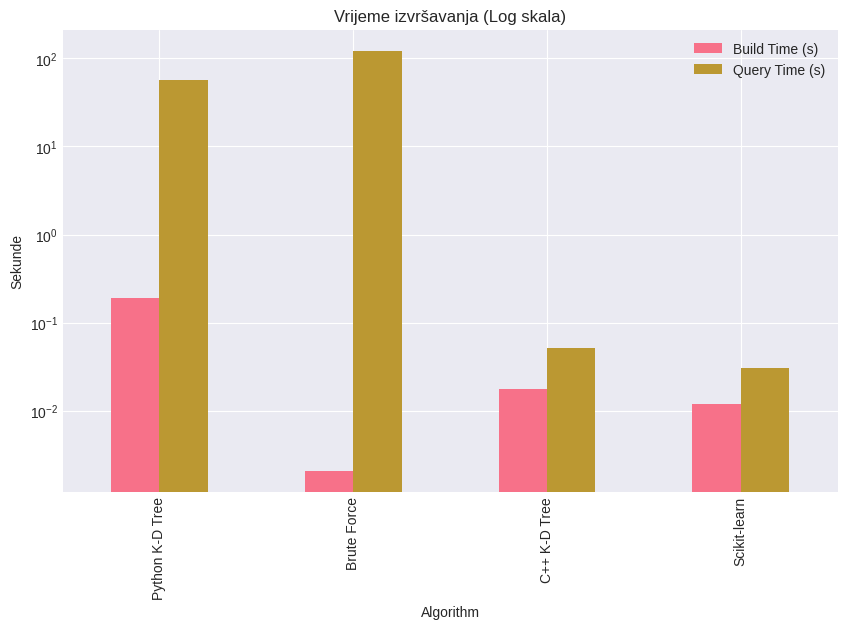

In [7]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# --- ASSUMPTION: The following classes from your PDF are already defined ---
# KDTree (Cell 2)
# kdtree_cpp (The compiled C++ module from Cell 3/4)
# BruteForceKNN (Cell 5)

def benchmark_big_data(n_samples=10000, n_features=5, k=5):
    print(f"--- Pokretanje benchmarka: {n_samples} uzoraka, {n_features} featura ---")

    # 1. Priprema podataka
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
                               n_informative=3, n_redundant=0, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    results = []

    configs = [
        ("Python K-D Tree", "custom_py"),
        ("Brute Force", "brute"),
        ("C++ K-D Tree", "cpp"),
        ("Scikit-learn", "sklearn")
    ]

    for name, key in configs:
        print(f"Testiram {name}...")

        # Fit / Build faza
        start_build = time.time()
        if key == "custom_py":
            model = KDTree() # Tvoja klasa iz Cell 2
            model.build(X_train, y_train)
        elif key == "brute":
            model = BruteForceKNN() # Tvoja klasa iz Cell 5
            model.fit(X_train, y_train)
        elif key == "cpp":
            if kdtree_cpp is None: continue
            model = kdtree_cpp.KDTreeCpp()
            model.build(X_train.astype(np.float64), y_train.astype(np.int32))
        elif key == "sklearn":
            model = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
            model.fit(X_train, y_train)
        build_time = time.time() - start_build

        # Prediction / Query faza
        start_query = time.time()
        if key == "custom_py":
            # POPRAVKA: Pozivamo predict za svaku tačku pojedinačno
            preds = np.array([model.predict(x, k) for x in X_test])
        elif key == "cpp":
            preds = np.array([model.predict(x.astype(np.float64), k) for x in X_test])
        else:
            # BruteForce i Sklearn u tvom kodu već podržavaju cijelu matricu
            preds = model.predict(X_test)
        query_time = time.time() - start_query

        accuracy = np.mean(preds == y_test)

        results.append({
            "Algorithm": name,
            "Build Time (s)": build_time,
            "Query Time (s)": query_time,
            "Accuracy": accuracy
        })

    # Prikaz rezultata
    df_results = pd.DataFrame(results)
    print("\n", df_results.to_string(index=False))

    # Vizuelizacija
    df_results.set_index("Algorithm")[["Build Time (s)", "Query Time (s)"]].plot(kind="bar", logy=True, figsize=(10, 6))
    plt.title("Vrijeme izvršavanja (Log skala)")
    plt.ylabel("Sekunde")
    plt.show()

# Savjet: Počni sa 5000 ili 10000 uzoraka.
# 25000 u običnom Pythonu može potrajati par minuta.
benchmark_big_data(n_samples=10000)

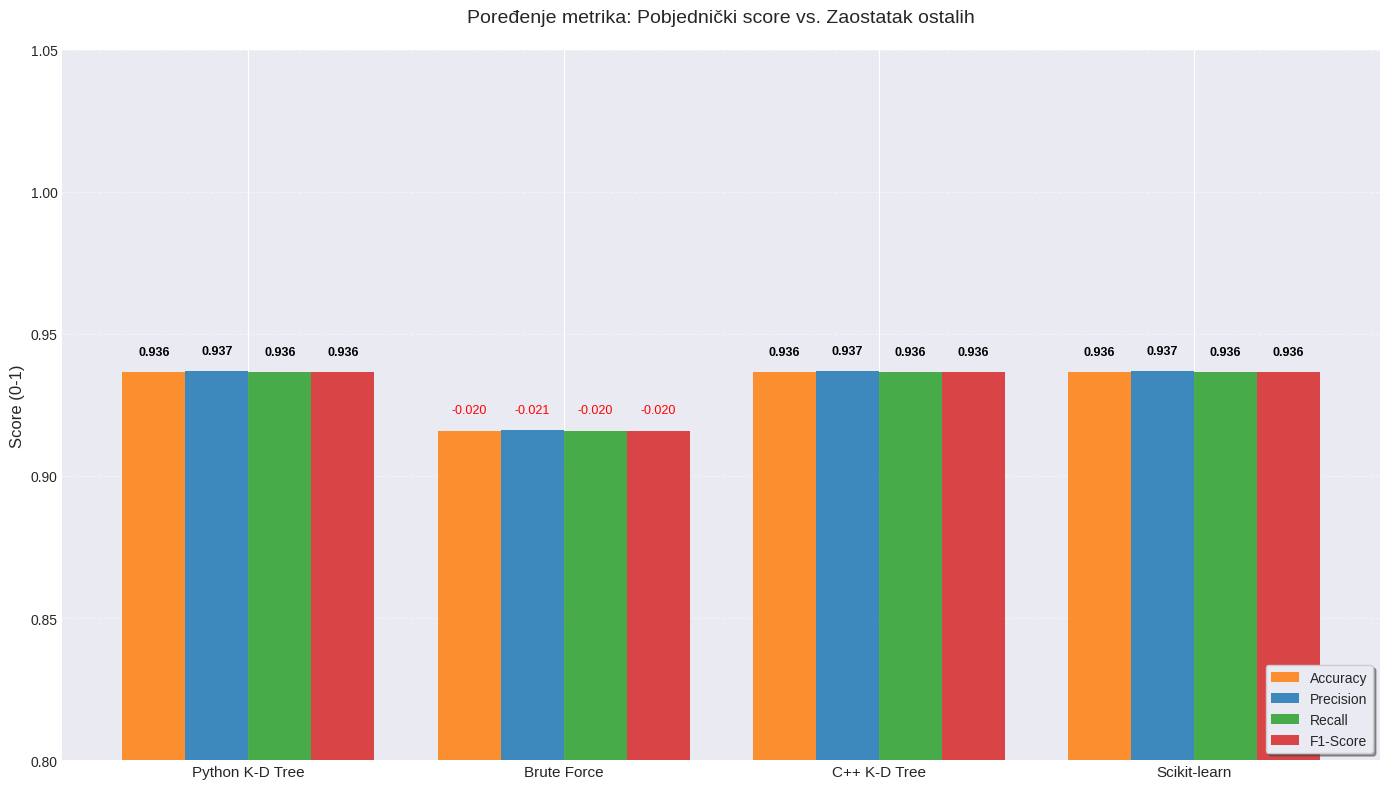

In [17]:
def plot_annotated_performance(df_metrike):
    plt.figure(figsize=(14, 8))

    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    algorithms = df_metrike["Algorithm"].tolist()

    # Pronalazimo najbolje vrijednosti za svaku metriku
    best_values = df_metrike[metrics].max()

    x = np.arange(len(algorithms))
    width = 0.2  # širina stubića
    colors = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728']

    # Crtanje stubića za svaku metriku
    for i, metric in enumerate(metrics):
        offset = (i - 1.5) * width
        bars = plt.bar(x + offset, df_metrike[metric], width, label=metric, color=colors[i], alpha=0.85)

        # Dodavanje anotacija iznad svakog stubića
        best_val = best_values[metric]
        for j, bar in enumerate(bars):
            current_val = df_metrike.iloc[j][metric]

            if current_val == best_val:
                # Ako je najbolji, pišemo puni broj (npr. 0.936)
                label = f"{current_val:.3f}"
                weight = 'bold'
                color = 'black'
            else:
                # Ako nije najbolji, pišemo razliku (npr. -0.021)
                diff = current_val - best_val
                label = f"{diff:+.3f}"
                weight = 'normal'
                color = 'red' # Crvena boja za razliku (zaostatak)

            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                     label, ha='center', va='bottom', fontsize=9,
                     fontweight=weight, color=color, rotation=0)

    # Estetika grafikona
    plt.title('Poređenje metrika: Pobjednički score vs. Zaostatak ostalih', fontsize=14, pad=20)
    plt.ylabel('Score (0-1)', fontsize=12)
    plt.xticks(x, algorithms, fontsize=11)
    plt.ylim(0.8, 1.05) # Ostavljamo prostora na vrhu za labelice
    plt.legend(loc='lower right', frameon=True, shadow=True)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Poziv funkcije
plot_annotated_performance(df_metrike)

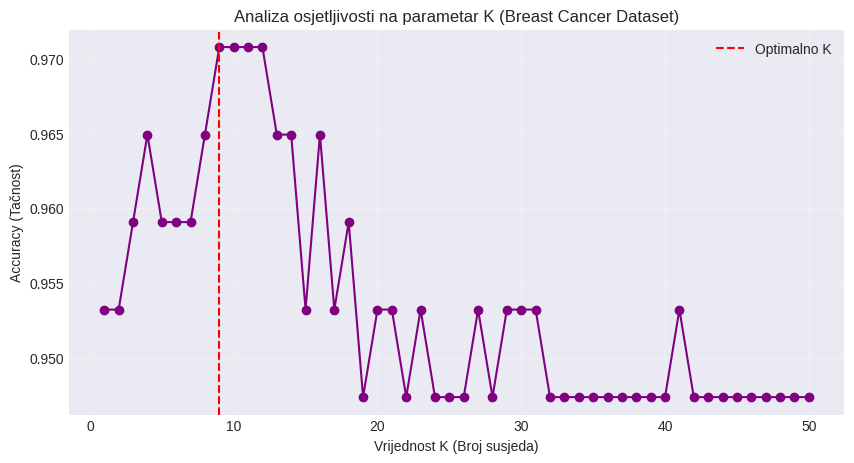

In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

def plot_k_sensitivity():
    data = load_breast_cancer()
    X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    ks = range(1, 51)
    accuracies = []

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        accuracies.append(knn.score(X_test, y_test))

    plt.figure(figsize=(10, 5))
    plt.plot(ks, accuracies, marker='o', linestyle='-', color='purple')
    plt.title('Analiza osjetljivosti na parametar K (Breast Cancer Dataset)')
    plt.xlabel('Vrijednost K (Broj susjeda)')
    plt.ylabel('Accuracy (Tačnost)')
    plt.grid(True, alpha=0.3)
    plt.axvline(x=accuracies.index(max(accuracies))+1, color='red', linestyle='--', label='Optimalno K')
    plt.legend()
    plt.show()

plot_k_sensitivity()

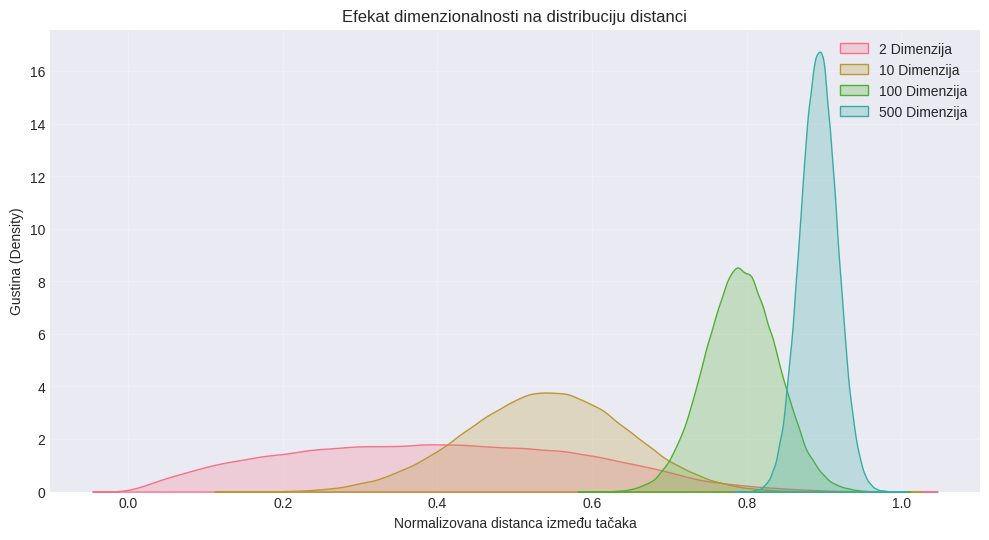

In [13]:
def plot_curse_of_dimensionality():
    n_points = 500
    dimensions = [2, 10, 100, 500]

    plt.figure(figsize=(12, 6))

    for d in dimensions:
        # Generišemo nasumične tačke u D dimenzija
        points = np.random.random((n_points, d))
        # Računamo sve međusobne distance (pairwise distances)
        from sklearn.metrics import pairwise_distances
        dists = pairwise_distances(points).flatten()
        # Uzimamo samo distance koje nisu 0 (različite tačke)
        dists = dists[dists > 0]

        # Normalizujemo distance radi poređenja
        dists = dists / np.max(dists)

        sns.kdeplot(dists, label=f'{d} Dimenzija', fill=True)

    plt.title('Efekat dimenzionalnosti na distribuciju distanci')
    plt.xlabel('Normalizovana distanca između tačaka')
    plt.ylabel('Gustina (Density)')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

plot_curse_of_dimensionality()

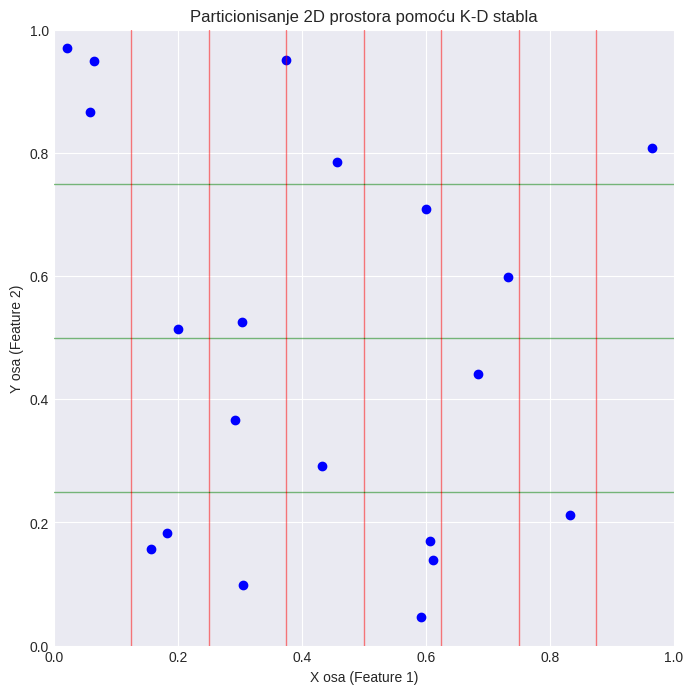

In [14]:
def plot_kd_tree_boundaries():
    # Mali set tačaka za preglednost
    np.random.seed(42)
    X = np.random.rand(20, 2)

    from sklearn.neighbors import KDTree as SK_KDTree
    tree = SK_KDTree(X, leaf_size=1)

    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], c='blue', label='Tačke podataka')

    def draw_boundary(node_data, x_range, y_range, depth=0):
        # Ova funkcija simulira vizualizaciju particionisanja
        if depth > 4: return

        axis = depth % 2
        # Pronalazimo medijanu za crtanje linije (pojednostavljeno)
        mid = (x_range[0] + x_range[1])/2 if axis==0 else (y_range[0] + y_range[1])/2

        if axis == 0: # Vertikalni rez
            plt.plot([mid, mid], y_range, color='red', alpha=0.5, linewidth=1)
            draw_boundary(None, [x_range[0], mid], y_range, depth+1)
            draw_boundary(None, [mid, x_range[1]], y_range, depth+1)
        else: # Horizontalni rez
            plt.plot(x_range, [mid, mid], color='green', alpha=0.5, linewidth=1)
            draw_boundary(None, x_range, [y_range[0], mid], depth+1)
            draw_boundary(None, x_range, [mid, y_range[1]], depth+1)

    draw_boundary(None, [0, 1], [0, 1], 0)
    plt.title('Particionisanje 2D prostora pomoću K-D stabla')
    plt.xlabel('X osa (Feature 1)')
    plt.ylabel('Y osa (Feature 2)')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

plot_kd_tree_boundaries()

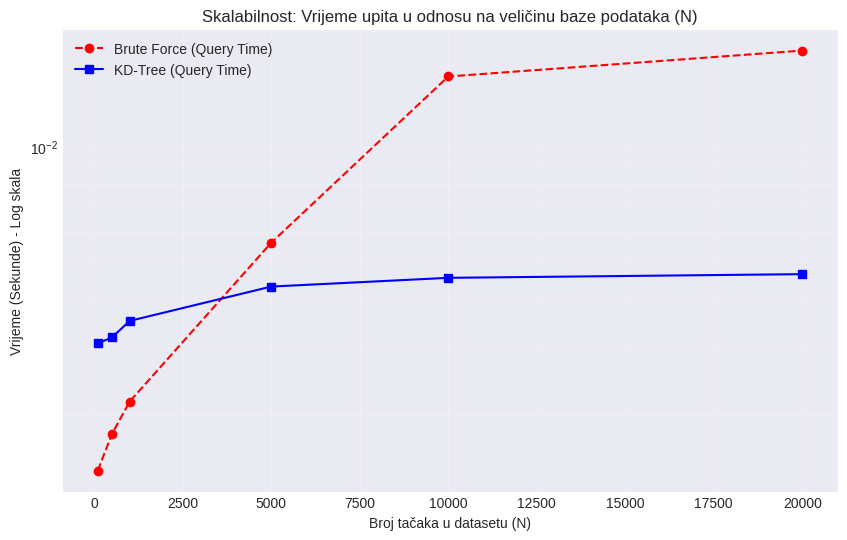

In [15]:
def plot_scalability_analysis():
    ns = [100, 500, 1000, 5000, 10000, 20000]
    brute_times = []
    kdtree_times = []

    for n in ns:
        X, y = make_classification(n_samples=n, n_features=5, random_state=42)

        # Brute Force
        knn_brute = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
        knn_brute.fit(X, y)
        start = time.time()
        knn_brute.predict(X[:100]) # Testiramo na prvih 100 tačaka
        brute_times.append(time.time() - start)

        # KD-Tree
        knn_kd = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
        knn_kd.fit(X, y)
        start = time.time()
        knn_kd.predict(X[:100])
        kdtree_times.append(time.time() - start)

    plt.figure(figsize=(10, 6))
    plt.plot(ns, brute_times, 'o--', label='Brute Force (Query Time)', color='red')
    plt.plot(ns, kdtree_times, 's-', label='KD-Tree (Query Time)', color='blue')

    plt.yscale('log') # Logaritamska skala je obavezna ovdje
    plt.title('Skalabilnost: Vrijeme upita u odnosu na veličinu baze podataka (N)')
    plt.xlabel('Broj tačaka u datasetu (N)')
    plt.ylabel('Vrijeme (Sekunde) - Log skala')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

plot_scalability_analysis()

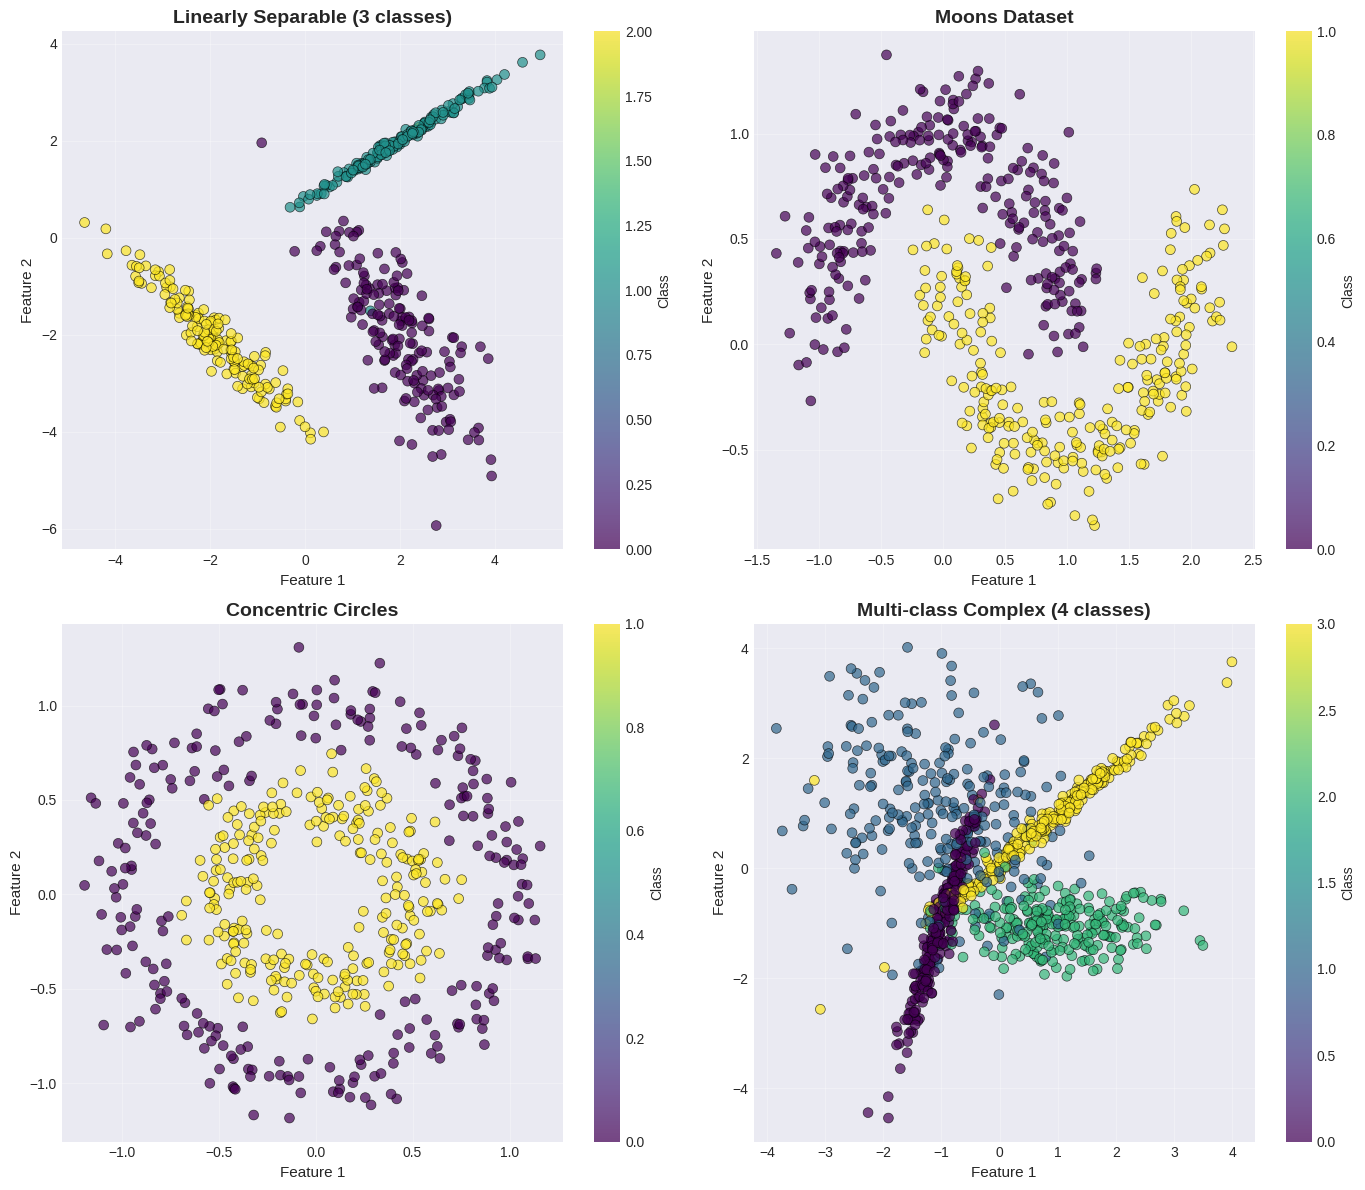

Dataset shapes: [(500, 2), (500, 2), (500, 2), (1000, 2)]


In [ ]:
# Cell 6: Generate Synthetic Dataset

# Generate multiple synthetic datasets
np.random.seed(42)

# Dataset 1: Linearly separable
X1, y1 = make_classification(n_samples=500, n_features=2, n_redundant=0,
                             n_informative=2, n_clusters_per_class=1,
                             n_classes=3, class_sep=2.0, random_state=42)

# Dataset 2: Moon shaped
X2, y2 = make_moons(n_samples=500, noise=0.15, random_state=42)

# Dataset 3: Concentric circles
X3, y3 = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)

# Dataset 4: Multi-class complex
X4, y4 = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                             n_informative=2, n_clusters_per_class=1, # Changed from 2 to 1
                             n_classes=4, class_sep=1.0, random_state=42)

datasets = [
    (X1, y1, "Linearly Separable (3 classes)"),
    (X2, y2, "Moons Dataset"),
    (X3, y3, "Concentric Circles"),
    (X4, y4, "Multi-class Complex (4 classes)")
]

# Visualize datasets
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (X, y, title) in enumerate(datasets):
    scatter = axes[idx].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis',
                               s=50, alpha=0.7, edgecolors='k', linewidth=0.5)
    axes[idx].set_title(title, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Feature 1', fontsize=11)
    axes[idx].set_ylabel('Feature 2', fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[idx], label='Class')

plt.tight_layout()
plt.savefig('synthetic_datasets.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Dataset shapes: {[X.shape for X, _, _ in datasets]}")

In [ ]:
# Cell 7: Performance Comparison on Synthetic Data

def compare_algorithms(X, y, k=5, test_size=0.3):
    """Compare all KNN implementations"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    results = {}

    # 1. Python K-D Tree
    print("Testing Python K-D Tree...")
    start = time.time()
    py_tree = KDTree()
    py_tree.build(X_train, y_train)
    build_time = time.time() - start

    start = time.time()
    py_predictions = np.array([py_tree.predict(x, k) for x in X_test])
    query_time = time.time() - start
    py_accuracy = np.mean(py_predictions == y_test)
    results['Python K-D Tree'] = {
        'build_time': build_time,
        'query_time': query_time,
        'total_time': build_time + query_time,
        'accuracy': py_accuracy
    }

    # 2. C++ K-D Tree (if available)
    if kdtree_cpp is not None:
        print("Testing C++ K-D Tree...")
        try:
            start = time.time()
            cpp_tree = kdtree_cpp.KDTreeCpp()
            cpp_tree.build(X_train.astype(np.float64), y_train.astype(np.int32))
            build_time = time.time() - start

            start = time.time()
            cpp_predictions = np.array([cpp_tree.predict(x.astype(np.float64), k) for x in X_test])
            query_time = time.time() - start
            cpp_accuracy = np.mean(cpp_predictions == y_test)
            results['C++ K-D Tree'] = {
                'build_time': build_time,
                'query_time': query_time,
                'total_time': build_time + query_time,
                'accuracy': cpp_accuracy
            }
        except Exception as e:
            print(f"C++ K-D Tree failed: {e}")

    # 3. Brute Force
    print("Testing Brute Force KNN...")
    start = time.time()
    brute_knn = BruteForceKNN()
    brute_knn.fit(X_train, y_train)
    brute_predictions = brute_knn.predict(X_test, k)
    brute_time = time.time() - start
    brute_accuracy = np.mean(brute_predictions == y_test)
    results['Brute Force'] = {
        'build_time': 0,
        'query_time': brute_time,
        'total_time': brute_time,
        'accuracy': brute_accuracy
    }

    # 4. Scikit-learn
    print("Testing Scikit-learn KNN...")
    start = time.time()
    sklearn_knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    sklearn_knn.fit(X_train, y_train)
    sklearn_predictions = sklearn_knn.predict(X_test)
    sklearn_time = time.time() - start
    sklearn_accuracy = np.mean(sklearn_predictions == y_test)
    results['Scikit-learn'] = {
        'build_time': 0,
        'query_time': sklearn_time,
        'total_time': sklearn_time,
        'accuracy': sklearn_accuracy
    }

    return results

# Test on first dataset
print("="*60)
print("PERFORMANCE COMPARISON ON SYNTHETIC DATA")
print("="*60)

X, y, name = datasets[0]
results = compare_algorithms(X, y, k=5)

# Display results
print(f"\nDataset: {name}")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Classes: {len(np.unique(y))}")
print("\n" + "-"*80)
print(f"{'Algorithm':<20} {'Build Time':<15} {'Query Time':<15} {'Total Time':<15} {'Accuracy':<10}")
print("-"*80)

for alg_name, metrics in results.items():
    print(f"{alg_name:<20} {metrics['build_time']:.6f}s{'':<6} {metrics['query_time']:.6f}s{'':<6} "
          f"{metrics['total_time']:.6f}s{'':<6} {metrics['accuracy']:.4f}")

print("-"*80)

PERFORMANCE COMPARISON ON SYNTHETIC DATA
Testing Python K-D Tree...
Testing C++ K-D Tree...
Testing Brute Force KNN...
Testing Scikit-learn KNN...

Dataset: Linearly Separable (3 classes)
Samples: 500, Features: 2, Classes: 3

--------------------------------------------------------------------------------
Algorithm            Build Time      Query Time      Total Time      Accuracy  
--------------------------------------------------------------------------------
Python K-D Tree      0.012333s       0.077867s       0.090200s       1.0000
C++ K-D Tree         0.000904s       0.001248s       0.002152s       1.0000
Brute Force          0.000000s       0.628325s       0.628325s       1.0000
Scikit-learn         0.000000s       0.010364s       0.010364s       1.0000
--------------------------------------------------------------------------------


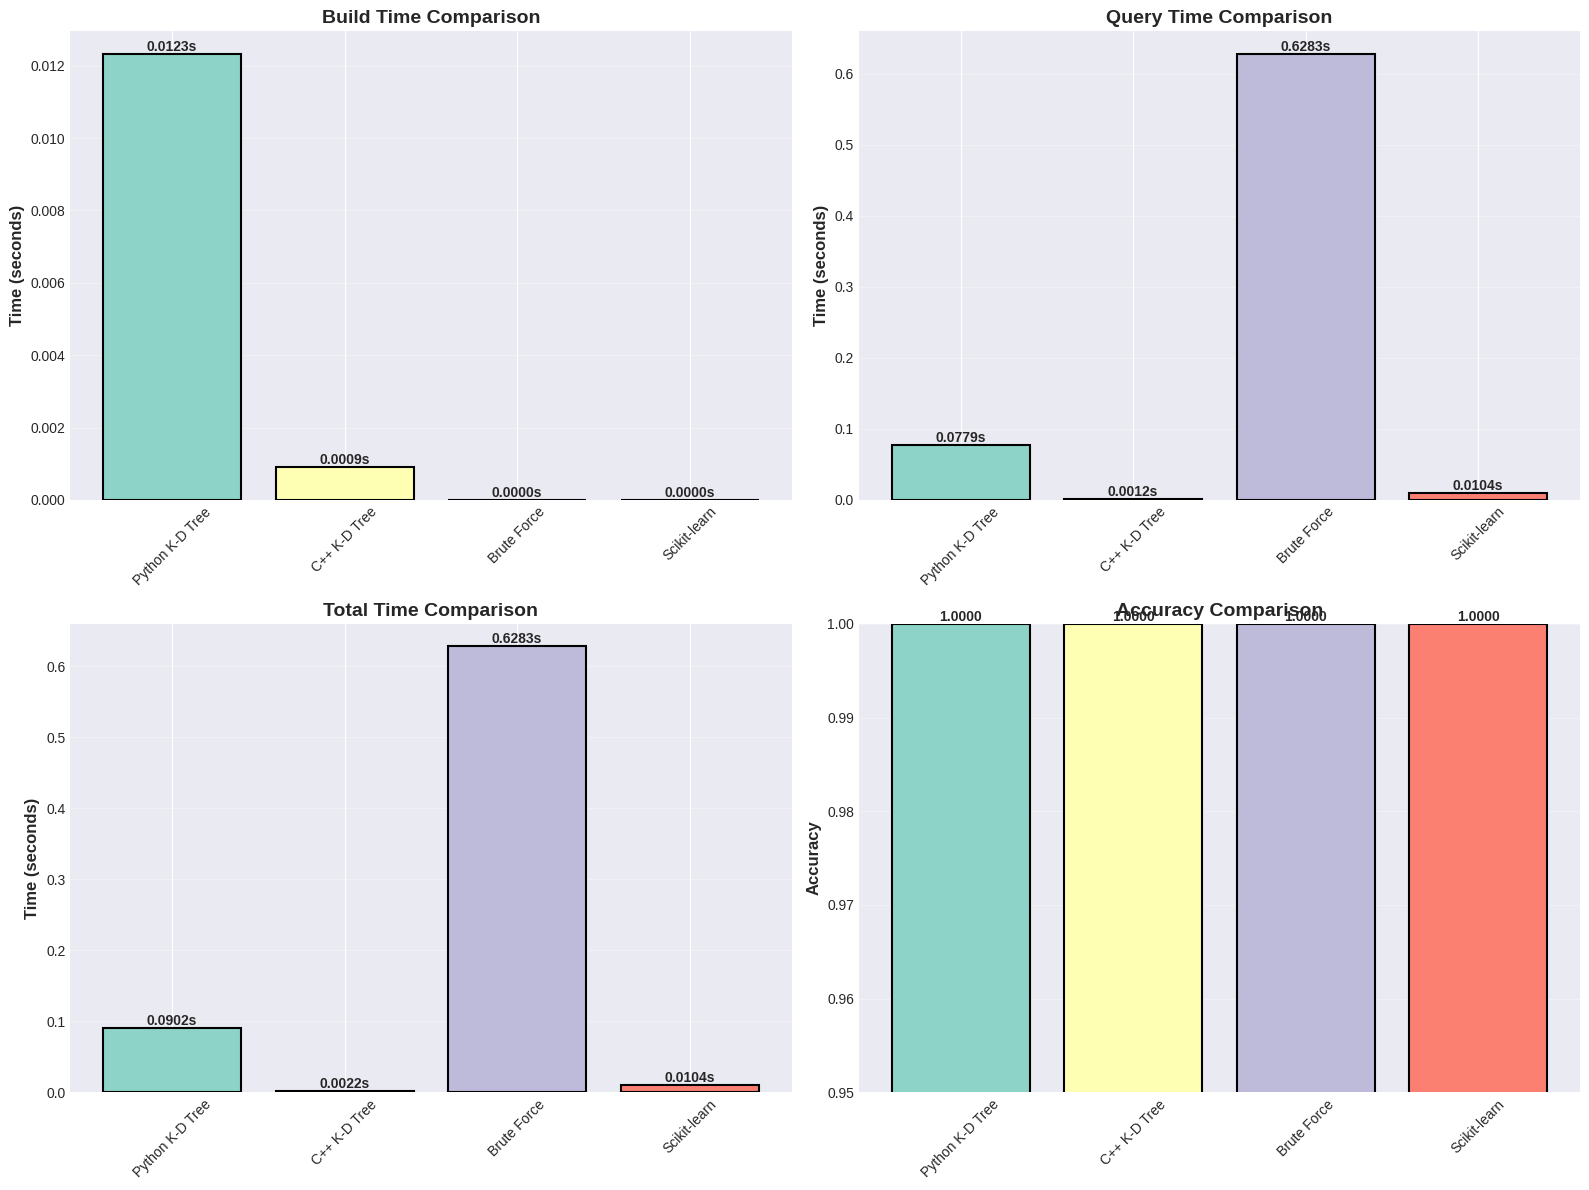

In [ ]:
# Cell 8: Visualize Performance Comparison

# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract data for plotting
algorithms = list(results.keys())
build_times = [results[alg]['build_time'] for alg in algorithms]
query_times = [results[alg]['query_time'] for alg in algorithms]
total_times = [results[alg]['total_time'] for alg in algorithms]
accuracies = [results[alg]['accuracy'] for alg in algorithms]

colors = plt.cm.Set3(range(len(algorithms)))

# Plot 1: Build Time Comparison
axes[0, 0].bar(algorithms, build_times, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Build Time Comparison', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(build_times):
    axes[0, 0].text(i, v, f'{v:.4f}s', ha='center', va='bottom', fontweight='bold')

# Plot 2: Query Time Comparison
axes[0, 1].bar(algorithms, query_times, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Query Time Comparison', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(query_times):
    axes[0, 1].text(i, v, f'{v:.4f}s', ha='center', va='bottom', fontweight='bold')

# Plot 3: Total Time Comparison
axes[1, 0].bar(algorithms, total_times, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Total Time Comparison', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(total_times):
    axes[1, 0].text(i, v, f'{v:.4f}s', ha='center', va='bottom', fontweight='bold')

# Plot 4: Accuracy Comparison
axes[1, 1].bar(algorithms, accuracies, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([min(accuracies) - 0.05, 1.0])
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(accuracies):
    axes[1, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


Processing Linearly Separable (3 classes)...


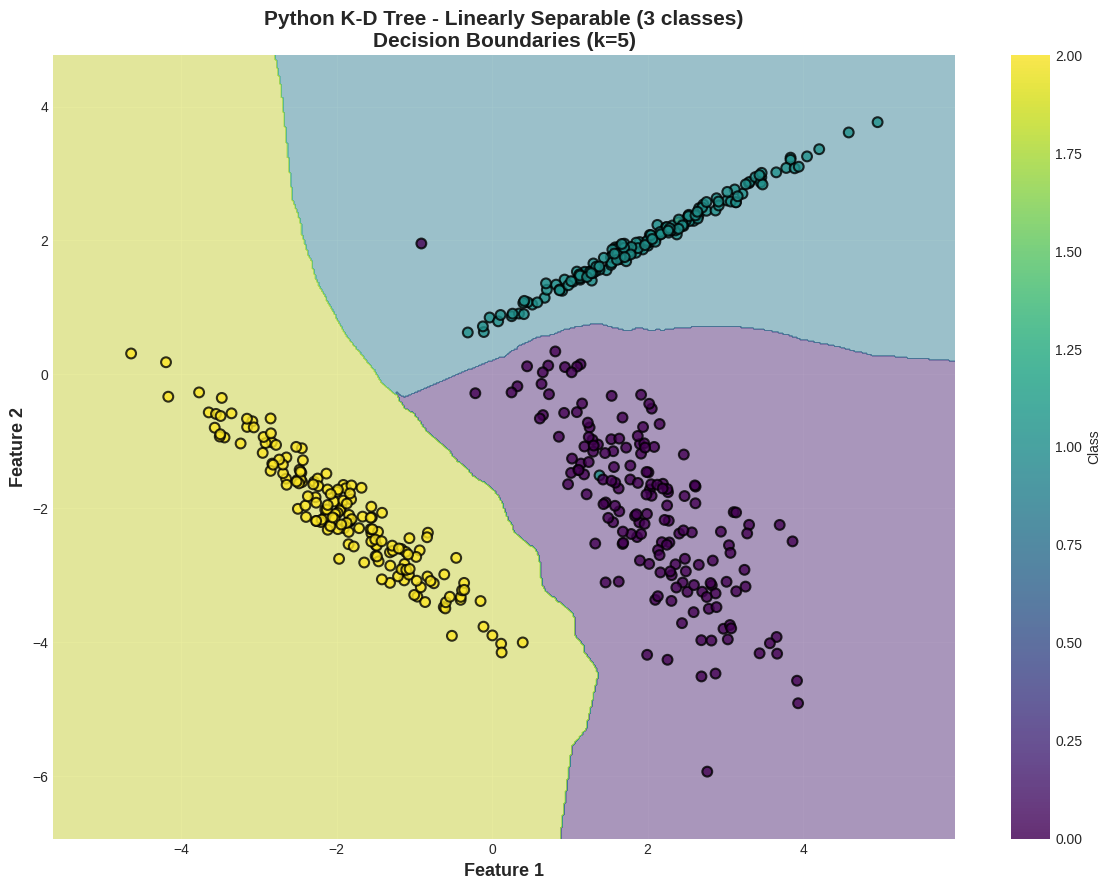

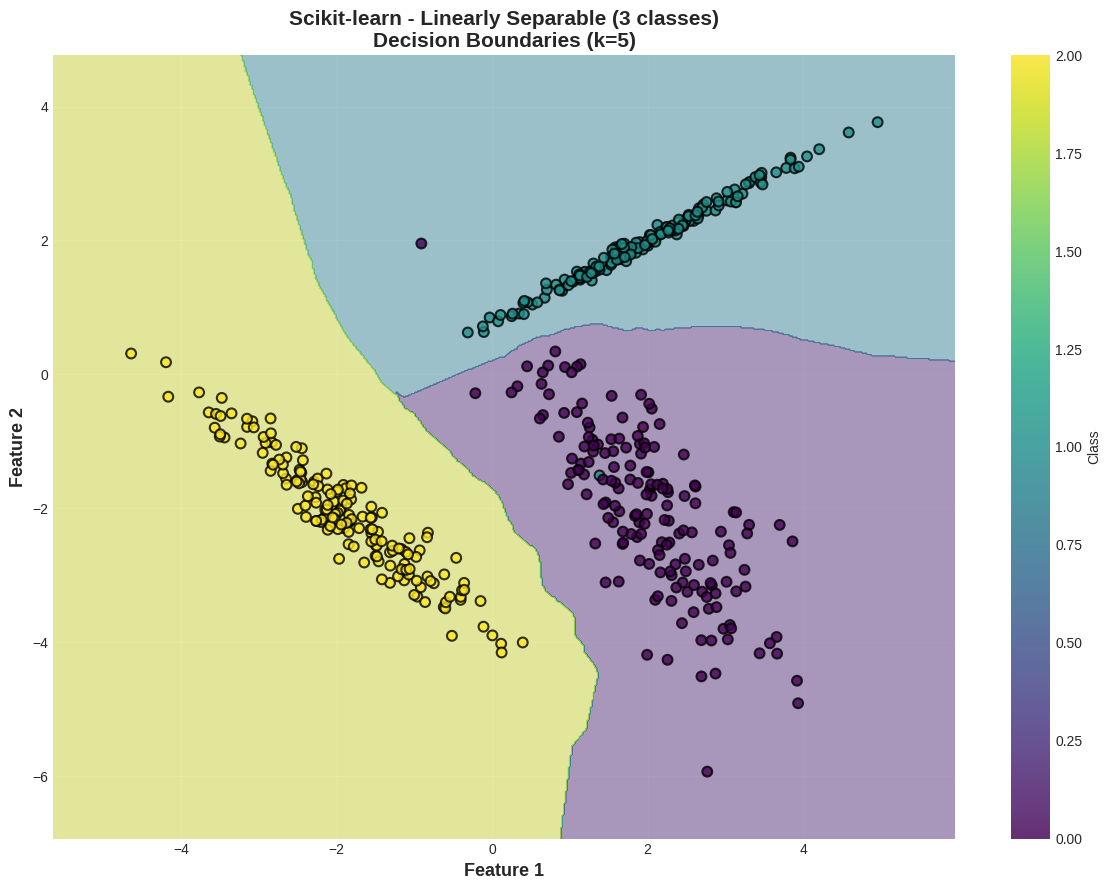

Processing Moons Dataset...


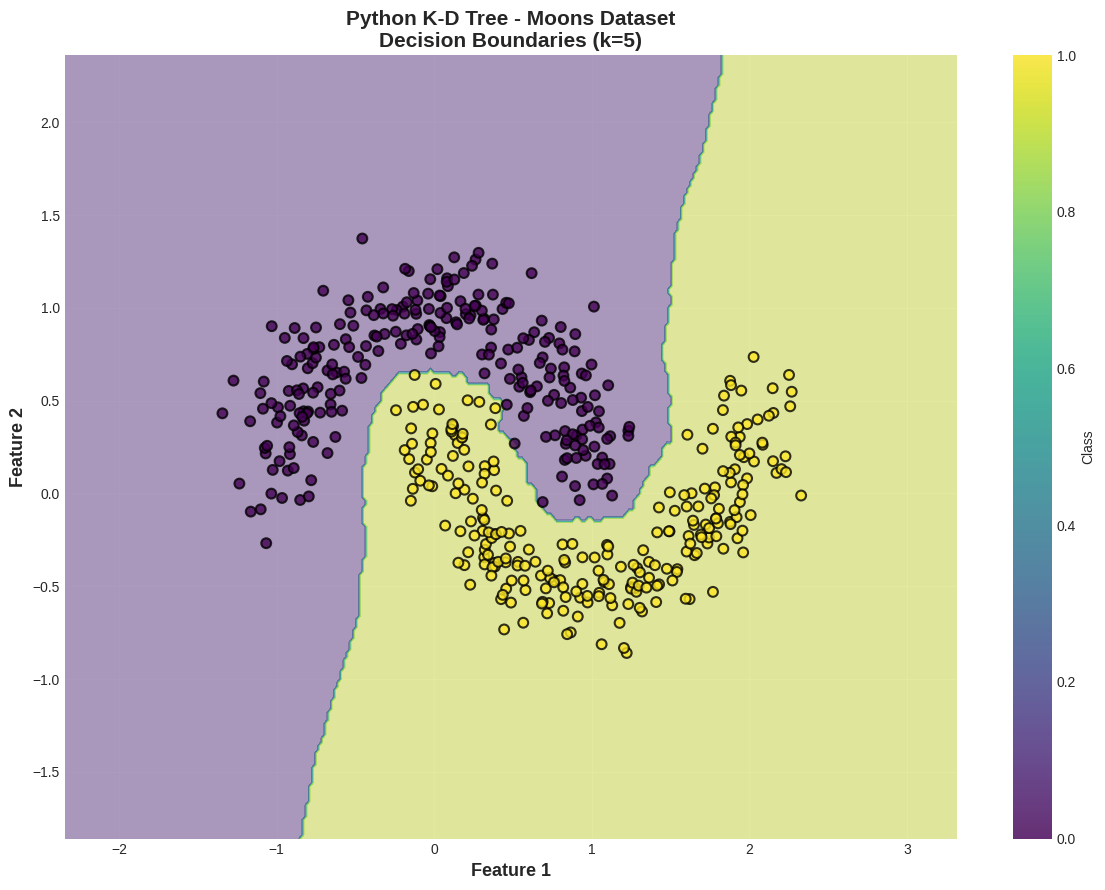

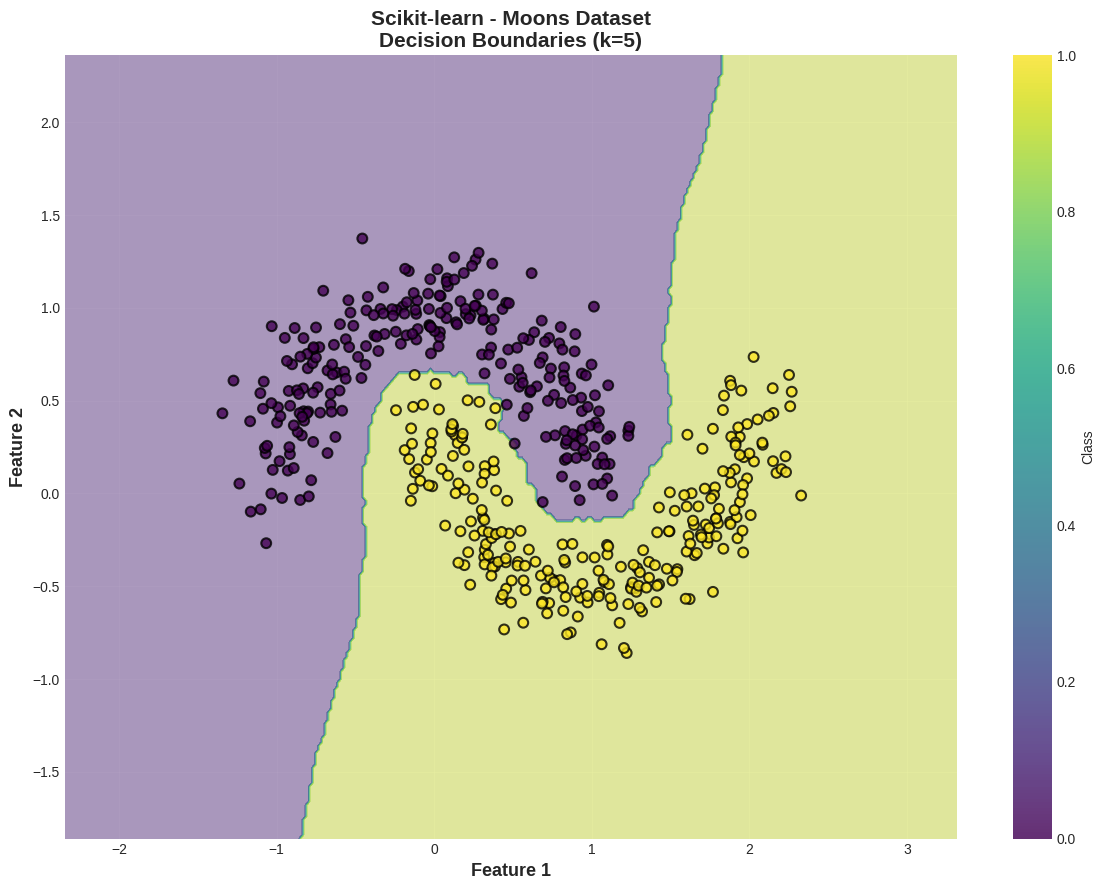

In [ ]:
# Cell 9: Decision Boundary Visualization

def plot_decision_boundary(X, y, classifier, title, k=5, resolution=0.02):
    """Plot decision boundaries for KNN classifier"""
    # Create mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Predict for each point in mesh
    if isinstance(classifier, KDTree):
        Z = np.array([classifier.predict(np.array([x, y]), k) for x, y in zip(xx.ravel(), yy.ravel())])
    elif isinstance(classifier, BruteForceKNN):
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()], k)
    else:  # sklearn
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(12, 9))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis',
                         s=50, edgecolors='black', linewidth=1.5, alpha=0.8)
    plt.colorbar(scatter, label='Class')
    plt.xlabel('Feature 1', fontsize=13, fontweight='bold')
    plt.ylabel('Feature 2', fontsize=13, fontweight='bold')
    plt.title(f'{title}\nDecision Boundaries (k={k})', fontsize=15, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()


for idx, (X, y, name) in enumerate(datasets[:2]):  # First 2 for speed
    print(f"Processing {name}...")

    # Python K-D Tree
    py_tree = KDTree()
    py_tree.build(X, y)
    fig = plot_decision_boundary(X, y, py_tree, f"Python K-D Tree - {name}", k=5)
    plt.savefig(f'boundary_kdtree_{idx}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Scikit-learn for comparison
    sklearn_knn = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
    sklearn_knn.fit(X, y)
    fig = plot_decision_boundary(X, y, sklearn_knn, f"Scikit-learn - {name}", k=5)
    plt.savefig(f'boundary_sklearn_{idx}.png', dpi=150, bbox_inches='tight')
    plt.show()


Visualizing effect of K on Moons Dataset...


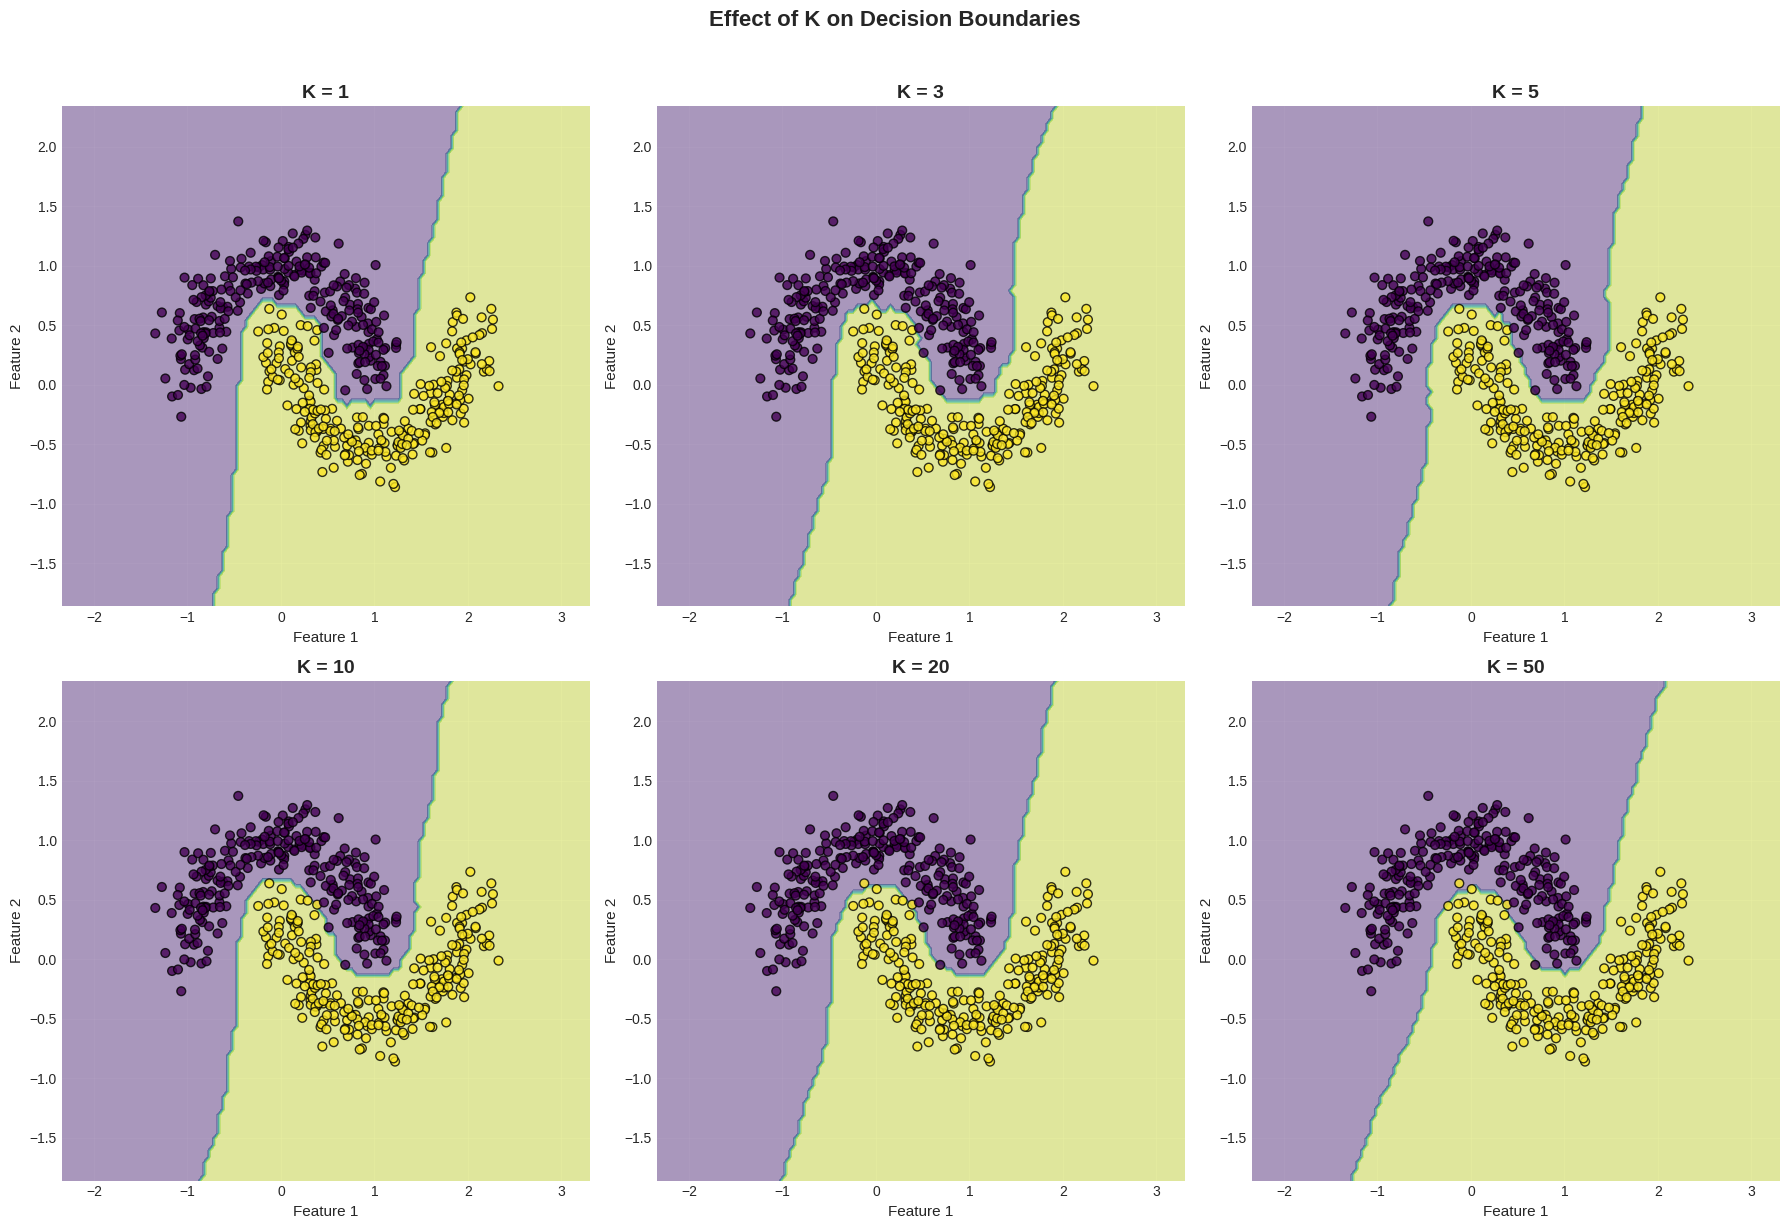

✓ K value effect visualization complete!


In [ ]:
# Cell 10: Visualize Effect of Different K Values

def visualize_k_effect(X, y, k_values=[1, 3, 5, 10, 20, 50]):
    """Visualize how k affects decision boundaries"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    for idx, k in enumerate(k_values):
        tree = KDTree()
        tree.build(X, y)

        Z = np.array([tree.predict(np.array([x, y]), k) for x, y in zip(xx.ravel(), yy.ravel())])
        Z = Z.reshape(xx.shape)

        axes[idx].contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
        axes[idx].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis',
                         s=40, edgecolors='black', linewidth=1, alpha=0.8)
        axes[idx].set_title(f'K = {k}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Feature 1', fontsize=11)
        axes[idx].set_ylabel('Feature 2', fontsize=11)
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle('Effect of K on Decision Boundaries', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

# Visualize k effect on moons dataset
X, y, name = datasets[1]  # Moons dataset
print(f"Visualizing effect of K on {name}...")
fig = visualize_k_effect(X, y)
plt.savefig('k_value_effect.png', dpi=150, bbox_inches='tight')
plt.show()


Visualizing KNN search process for different query points...

Query Point 1: [0. 0.]


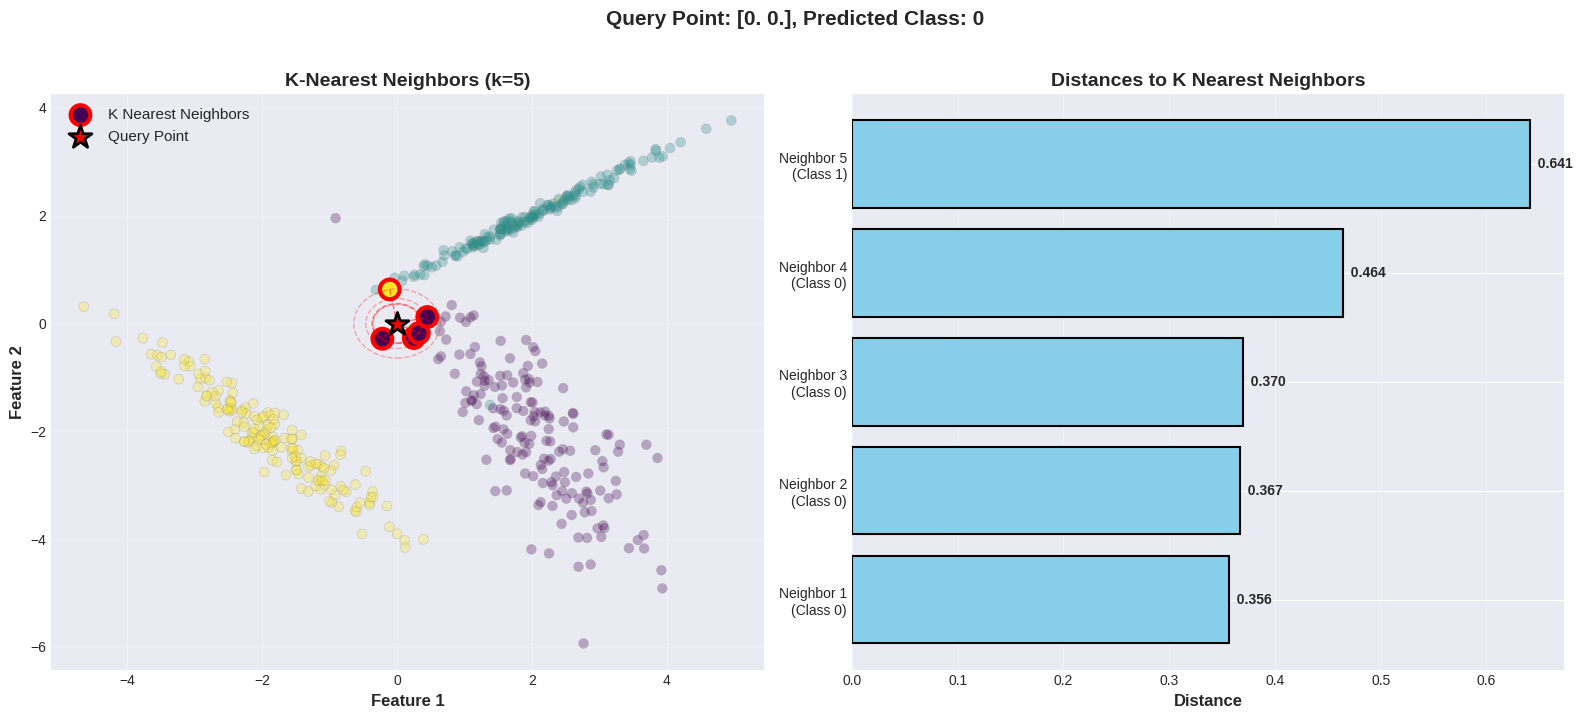

Predicted class: 0

Query Point 2: [2. 2.]


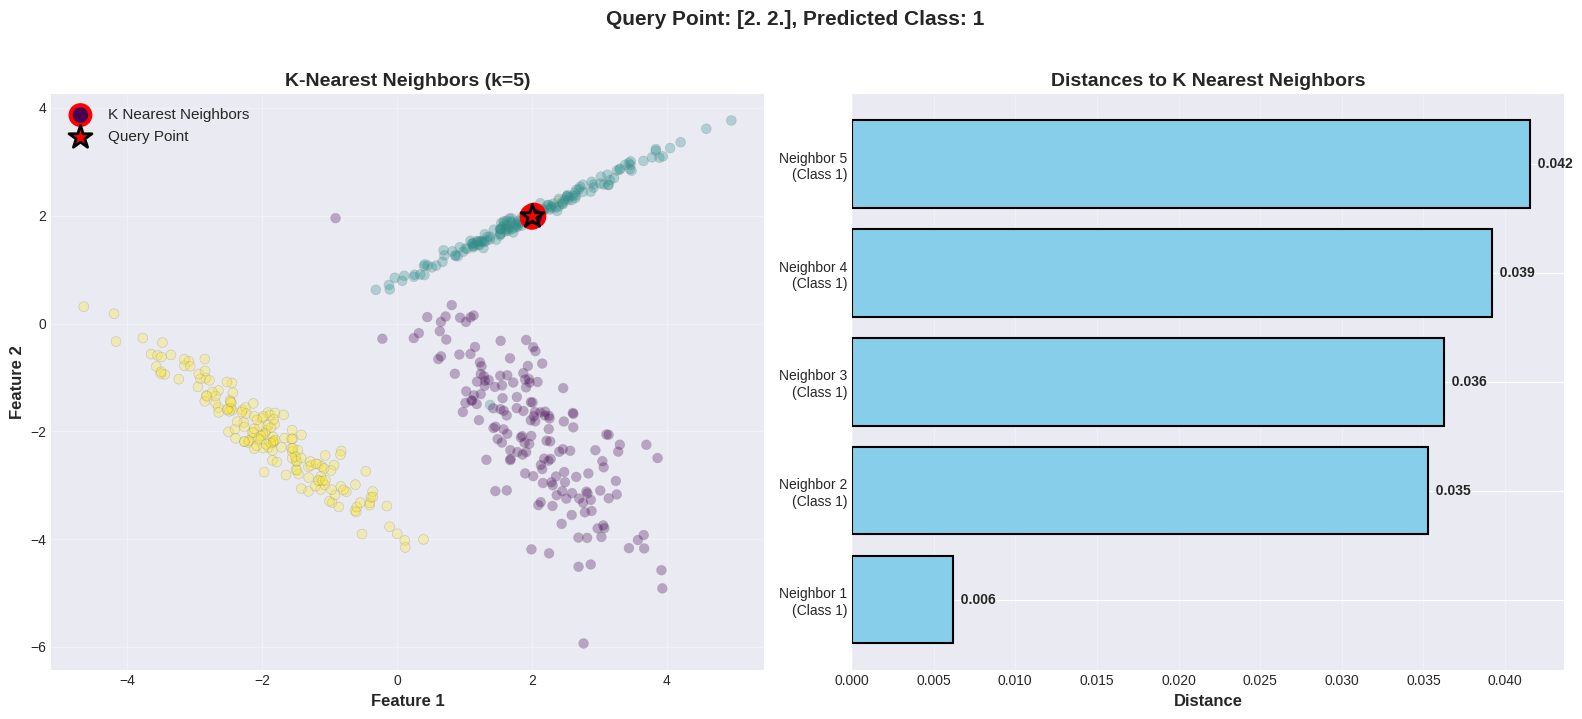

Predicted class: 1

Query Point 3: [-2. -2.]


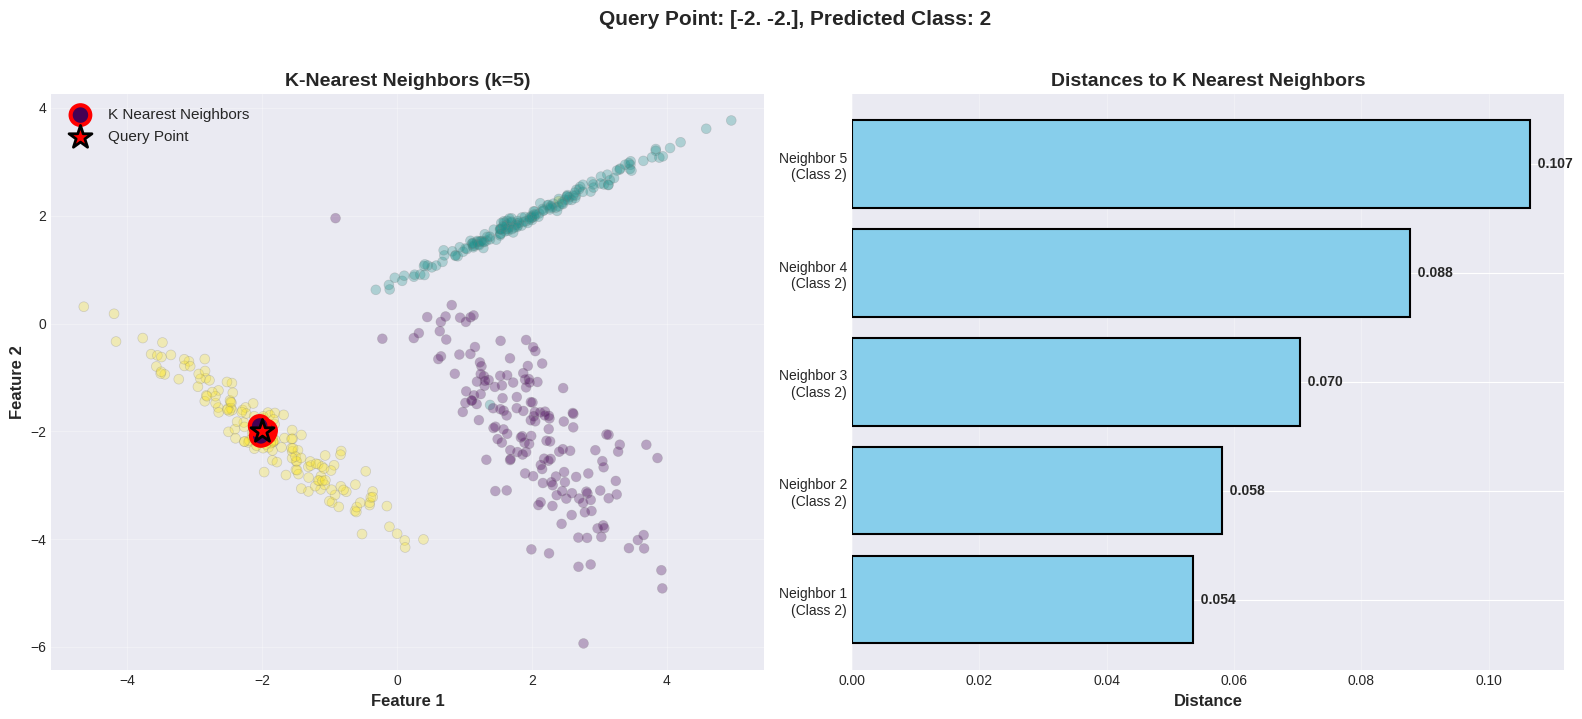

Predicted class: 2



In [ ]:
# Cell 11: Visualize KNN Search Process

def visualize_knn_search(X, y, query_point, k=5):
    """Visualize the KNN search for a specific query point"""
    tree = KDTree()
    tree.build(X, y)

    # Find k nearest neighbors
    neighbors = tree.query(query_point, k)
    neighbor_points = np.array([point for point, _ in neighbors])
    neighbor_labels = np.array([label for _, label in neighbors])

    # Calculate distances
    distances = [np.linalg.norm(query_point - point) for point, _ in neighbors]

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Left plot: Show neighbors
    axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis',
                   s=50, alpha=0.3, edgecolors='gray', linewidth=0.5)
    axes[0].scatter(neighbor_points[:, 0], neighbor_points[:, 1],
                   c=neighbor_labels, cmap='viridis', s=200,
                   edgecolors='red', linewidth=3, marker='o', label='K Nearest Neighbors')
    axes[0].scatter(query_point[0], query_point[1],
                   c='red', s=300, marker='*', edgecolors='black',
                   linewidth=2, label='Query Point', zorder=5)

    # Draw circles showing distances
    for i, (point, dist) in enumerate(zip(neighbor_points, distances)):
        circle = plt.Circle(query_point, dist, fill=False,
                          edgecolor='red', linestyle='--',
                          linewidth=1, alpha=0.3)
        axes[0].add_patch(circle)
        axes[0].plot([query_point[0], point[0]], [query_point[1], point[1]],
                    'r--', alpha=0.5, linewidth=1)

    axes[0].set_xlabel('Feature 1', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Feature 2', fontsize=12, fontweight='bold')
    axes[0].set_title(f'K-Nearest Neighbors (k={k})', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11, loc='best')
    axes[0].grid(True, alpha=0.3)

    # Right plot: Distance distribution
    axes[1].barh(range(k), distances, color='skyblue', edgecolor='black', linewidth=1.5)
    axes[1].set_yticks(range(k))
    axes[1].set_yticklabels([f'Neighbor {i+1}\n(Class {label})'
                            for i, label in enumerate(neighbor_labels)])
    axes[1].set_xlabel('Distance', fontsize=12, fontweight='bold')
    axes[1].set_title('Distances to K Nearest Neighbors', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')

    for i, dist in enumerate(distances):
        axes[1].text(dist, i, f'  {dist:.3f}', va='center', fontweight='bold')

    # Prediction
    predicted_class = tree.predict(query_point, k)
    fig.suptitle(f'Query Point: {query_point}, Predicted Class: {predicted_class}',
                fontsize=15, fontweight='bold', y=1.02)

    plt.tight_layout()
    return fig, predicted_class

# Test on multiple query points
X, y, name = datasets[0]
query_points = [
    np.array([0.0, 0.0]),
    np.array([2.0, 2.0]),
    np.array([-2.0, -2.0])
]

print("Visualizing KNN search process for different query points...\n")
for i, qp in enumerate(query_points):
    print(f"Query Point {i+1}: {qp}")
    fig, pred = visualize_knn_search(X, y, qp, k=5)
    plt.savefig(f'knn_search_viz_{i}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Predicted class: {pred}\n")


Creating Voronoi visualization for Moons Dataset...

K = 1
Computing predictions for 16848 points...


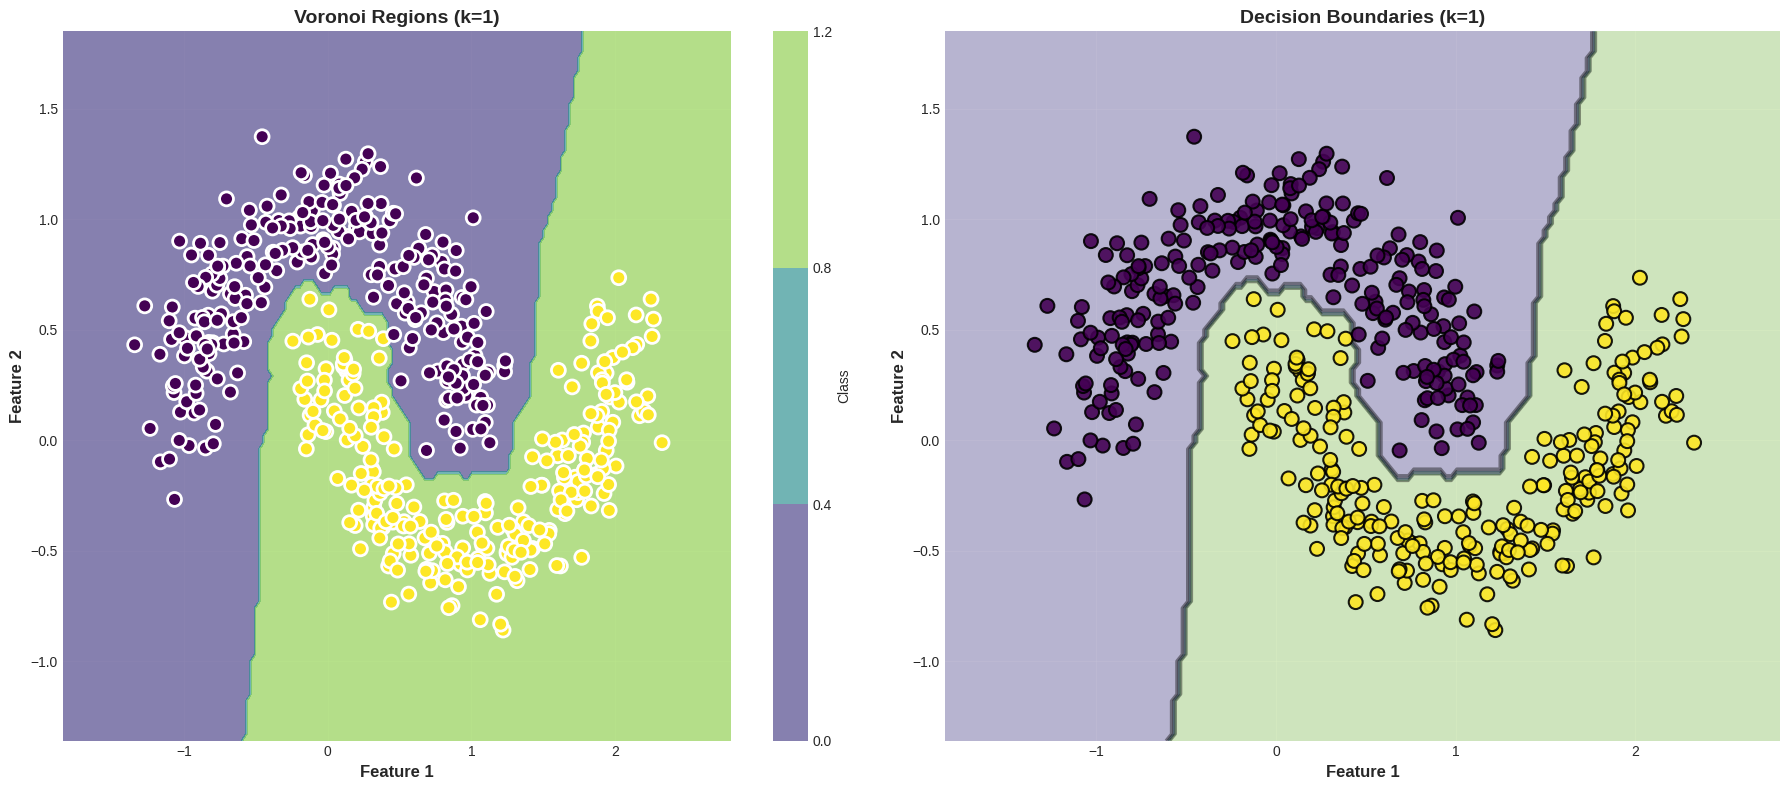


K = 5
Computing predictions for 16848 points...


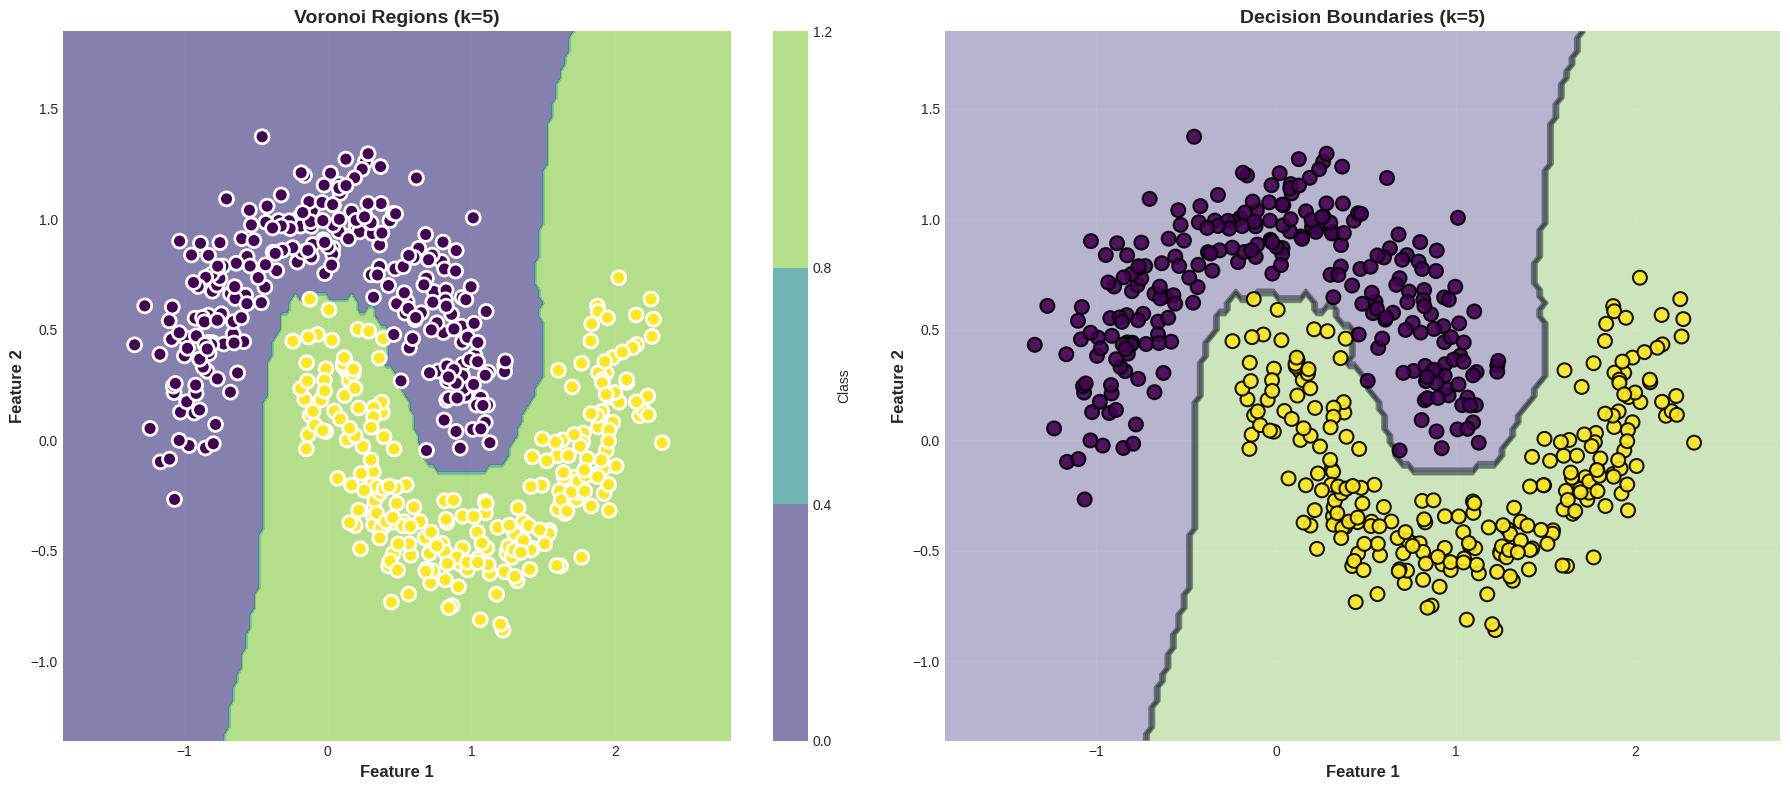

In [ ]:
# Cell 12: Voronoi-style Visualization of Classification

def create_voronoi_visualization(X, y, k=1, resolution=0.02):
    """Create a Voronoi-style visualization showing nearest neighbor regions"""
    tree = KDTree()
    tree.build(X, y)

    # Create fine mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Predict for each point
    print(f"Computing predictions for {xx.ravel().shape[0]} points...")
    Z = np.array([tree.predict(np.array([x, y]), k) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Left: Filled contours
    contour = axes[0].contourf(xx, yy, Z, alpha=0.6, cmap='viridis', levels=len(np.unique(y)))
    axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis',
                   s=100, edgecolors='white', linewidth=2, alpha=1.0, zorder=5)
    axes[0].set_xlabel('Feature 1', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Feature 2', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Voronoi Regions (k={k})', fontsize=14, fontweight='bold')
    plt.colorbar(contour, ax=axes[0], label='Class')
    axes[0].grid(True, alpha=0.3)

    # Right: Contour lines showing boundaries
    axes[1].contour(xx, yy, Z, colors='black', linewidths=2, alpha=0.4, levels=len(np.unique(y)))
    axes[1].contourf(xx, yy, Z, alpha=0.3, cmap='viridis', levels=len(np.unique(y)))
    axes[1].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis',
                   s=100, edgecolors='black', linewidth=1.5, alpha=0.9, zorder=5)
    axes[1].set_xlabel('Feature 1', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Feature 2', fontsize=12, fontweight='bold')
    axes[1].set_title(f'Decision Boundaries (k={k})', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Create Voronoi visualizations for different k values
X, y, name = datasets[1]  # Moons dataset
print(f"Creating Voronoi visualization for {name}...")

for k in [1, 5]:
    print(f"\nK = {k}")
    fig = create_voronoi_visualization(X, y, k=k, resolution=0.03)
    plt.savefig(f'voronoi_k{k}.png', dpi=150, bbox_inches='tight')
    plt.show()


In [ ]:
# Cell 13: Load Cities Dataset

import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/MyDrive/NASP/Dataset of all cities.csv'
try:
    # Load the dataset
    df_cities = pd.read_csv(file_path)
    # Display the first 10 rows of the dataframe
    print("Dataset loaded successfully. Here are the first 10 rows:")
    display(df_cities.head(10))

    print(f"\nDataset shape: {df_cities.shape}")
    print(f"Columns: {df_cities.columns.tolist()}")
    print(f"\nMissing values:\n{df_cities.isnull().sum()}")

except FileNotFoundError:
    print(f"Error: The file was not found at the specified path: {file_path}")
    print("Please make sure the file path is correct and the file exists.")
    print("You can find the path by right-clicking the file in the left-hand panel and selecting 'Copy path'.")
    df_cities = None


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully. Here are the first 10 rows:


city      country  population   latitude   longitude  \
0      Tokyo        Japan    31480498  35.685000  139.751389   
1   Shanghai        China    14608512  31.045556  121.399722   
2     Bombay        India    12692717  18.975000   72.825833   
3    Karachi     Pakistan    11627378  24.905600   67.082200   
4      Delhi        India    10928270  28.666667   77.216667   
5  New Delhi        India    10928270  28.600000   77.200000   
6     Manila  Philippines    10443877  14.604200  120.982200   
7     Moscow       Russia    10381288  55.752222   37.615556   
8      Seoul        Korea    10323448  37.598500  126.978300   
9  São Paulo       Brazil    10021437 -23.473293  -46.665803   

               region continent  
0        Eastern Asia      Asia  
1        Eastern Asia      Asia  
2       Southern Asia      Asia  
3       Southern Asia      Asia  
4       Southern Asia      Asia  
5       Southern Asia      Asia  
6  South-Eastern Asia      Asia  
7      Eastern Europe    Europe  
8        Eastern Asia      Asia  
9       South America  Americas


Dataset shape: (47605, 7)
Columns: ['city', 'country', 'population', 'latitude', 'longitude', 'region', 'continent']

Missing values:
city           0
country        0
population     0
latitude       0
longitude      0
region        85
continent     85
dtype: int64


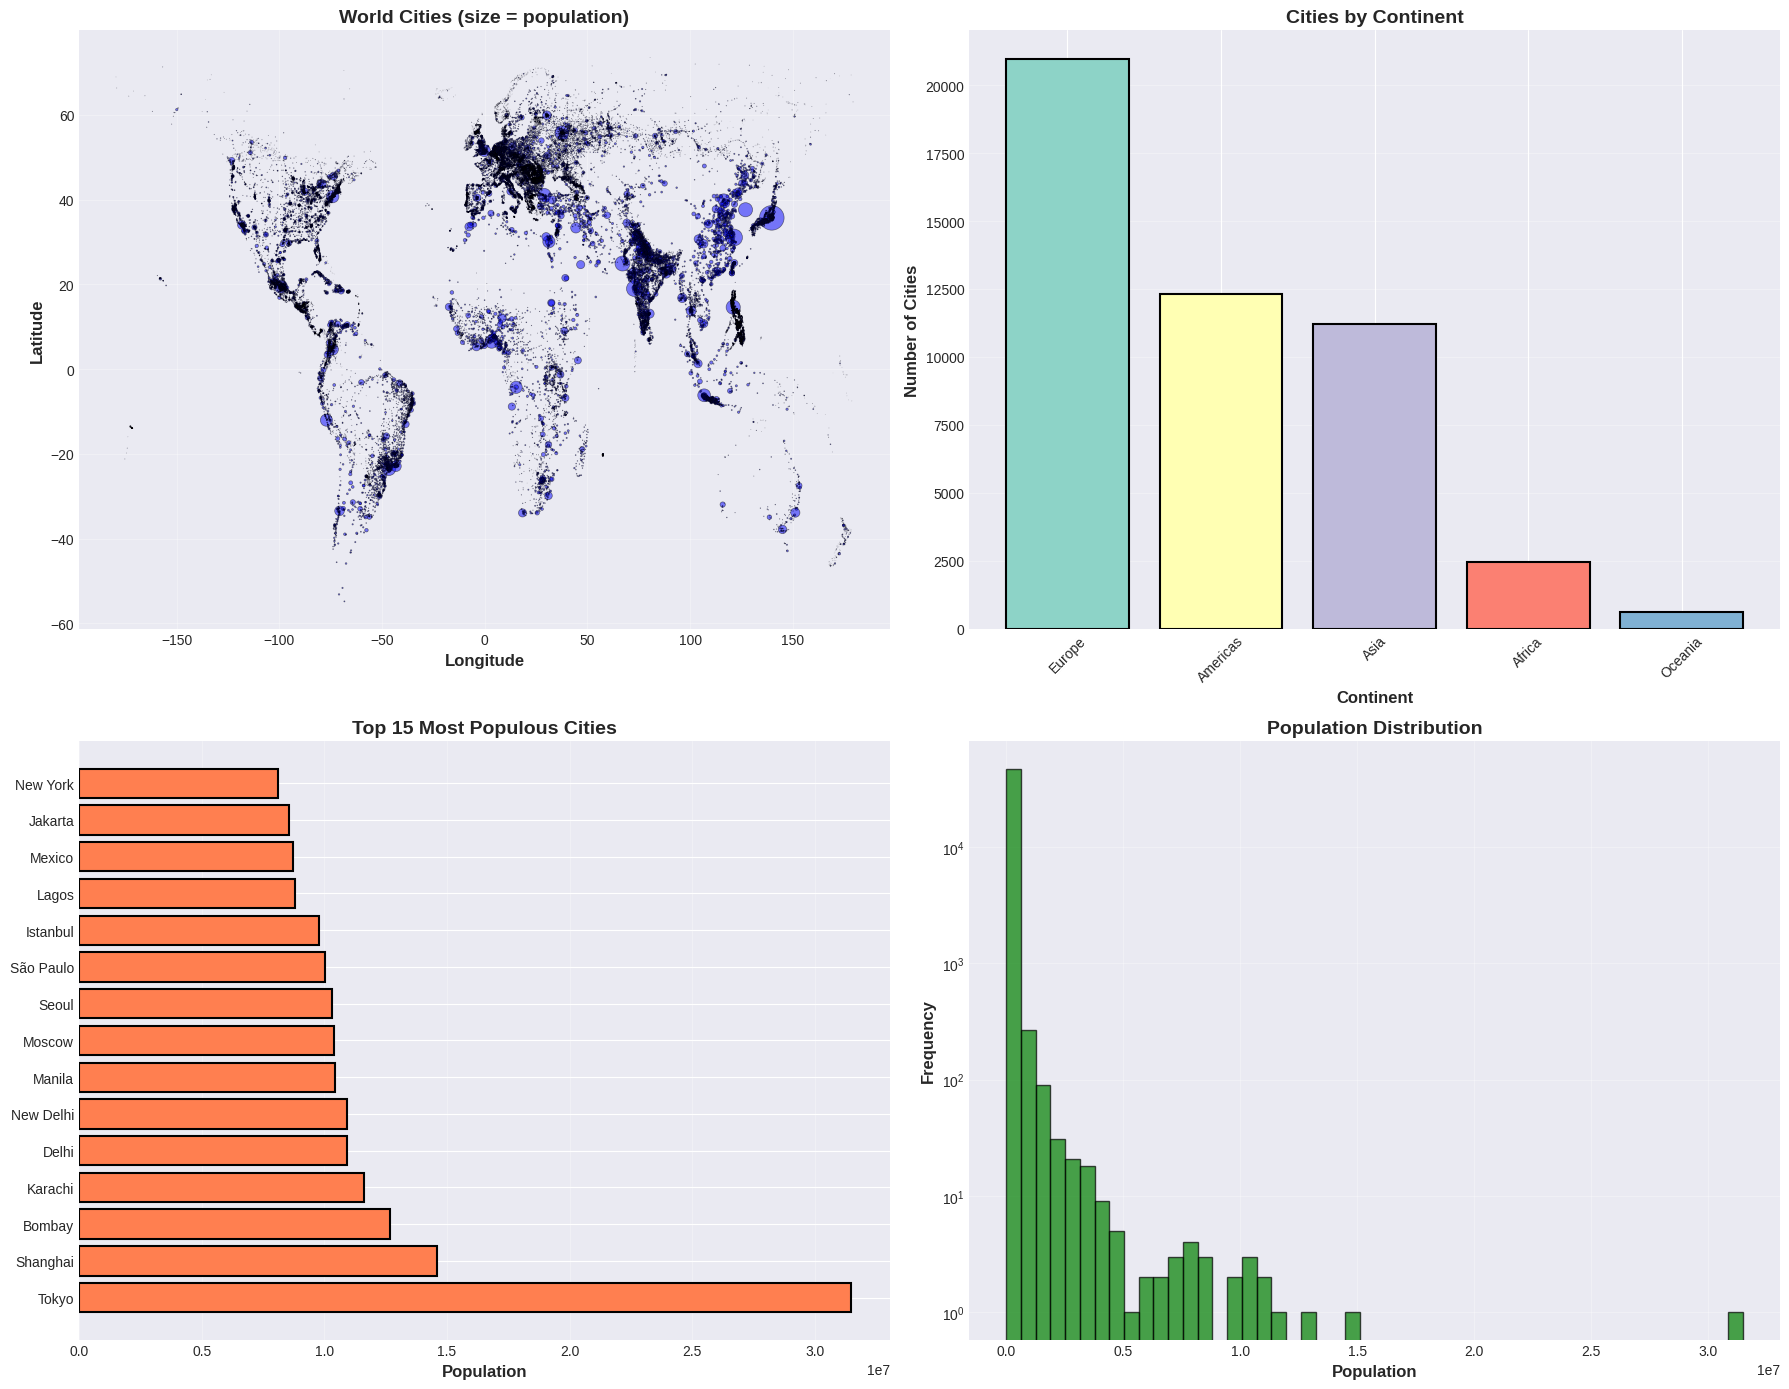

In [ ]:
# Cell 14: Visualize Cities Dataset

if df_cities is not None:
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Plot 1: World map of all cities
    axes[0, 0].scatter(df_cities['longitude'], df_cities['latitude'],
                      c='blue', s=df_cities['population']/100000,
                      alpha=0.5, edgecolors='black', linewidth=0.5)
    axes[0, 0].set_xlabel('Longitude', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Latitude', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('World Cities (size = population)', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Cities by continent
    continent_counts = df_cities['continent'].value_counts()
    axes[0, 1].bar(continent_counts.index, continent_counts.values,
                   color=plt.cm.Set3(range(len(continent_counts))),
                   edgecolor='black', linewidth=1.5)
    axes[0, 1].set_xlabel('Continent', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Cities', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Cities by Continent', fontsize=14, fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Plot 3: Top 15 most populous cities
    top_cities = df_cities.nlargest(15, 'population')
    axes[1, 0].barh(range(len(top_cities)), top_cities['population'],
                   color='coral', edgecolor='black', linewidth=1.5)
    axes[1, 0].set_yticks(range(len(top_cities)))
    axes[1, 0].set_yticklabels(top_cities['city'])
    axes[1, 0].set_xlabel('Population', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Top 15 Most Populous Cities', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Plot 4: Population distribution
    axes[1, 1].hist(df_cities['population'], bins=50, color='green',
                   alpha=0.7, edgecolor='black', linewidth=1)
    axes[1, 1].set_xlabel('Population', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Population Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cities_overview.png', dpi=150, bbox_inches='tight')
    plt.show()

else:
    print("Cannot visualize - dataset not loaded")

In [ ]:
# Cell 15: Find K Nearest Cities Function

def find_nearest_cities(city_name, k=10, df=None):
    """Find k nearest cities to a given city"""
    if df is None:
        df = df_cities

    # Find the query city
    city_data = df[df['city'].str.lower() == city_name.lower()]

    if len(city_data) == 0:
        print(f"City '{city_name}' not found in dataset!")
        print("Try one of these cities:")
        print(df['city'].head(20).tolist())
        return None

    # Get coordinates of query city
    query_city = city_data.iloc[0]
    query_coords = np.array([query_city['latitude'], query_city['longitude']])

    print(f"Found city: {query_city['city']}, {query_city['country']}")
    print(f"Coordinates: ({query_city['latitude']:.4f}, {query_city['longitude']:.4f})")
    print(f"Population: {query_city['population']:,}")
    print(f"Region: {query_city['region']}, Continent: {query_city['continent']}")
    print("\n" + "="*70)

    # Prepare data for K-D tree (all cities except query city)
    other_cities = df[df['city'] != query_city['city']].copy()
    X_cities = other_cities[['latitude', 'longitude']].values

    # Build K-D tree
    print(f"\nBuilding K-D tree with {len(X_cities)} cities...")
    tree = KDTree()
    # Use indices as labels for retrieval
    tree.build(X_cities, np.arange(len(X_cities)))

    # Find k nearest neighbors
    print(f"Finding {k} nearest cities...")
    neighbors = tree.query(query_coords, k)

    # Get neighbor city data
    neighbor_indices = [int(label) for _, label in neighbors]
    nearest_cities = other_cities.iloc[neighbor_indices].copy()

    # Calculate distances (in km using Haversine formula approximation)
    distances = []
    for idx in neighbor_indices:
        city = other_cities.iloc[idx]
        lat1, lon1 = query_coords
        lat2, lon2 = city['latitude'], city['longitude']

        # Haversine formula
        R = 6371  # Earth radius in km
        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        distance = R * c
        distances.append(distance)

    nearest_cities['distance_km'] = distances

    # Display results
    print(f"\n{k} Nearest Cities to {query_city['city']}:")
    print("="*70)
    for i, (idx, row) in enumerate(nearest_cities.iterrows(), 1):
        print(f"{i}. {row['city']}, {row['country']} - {row['distance_km']:.2f} km")
        print(f"   Population: {row['population']:,} | Region: {row['region']}")

    return query_city, nearest_cities


In [ ]:
# Cell 16: Test Find Nearest Cities

if df_cities is not None:
    # Test with different cities
    test_cities = ['Tokyo', 'New York', 'London', 'Sydney']

    for city in test_cities:
        print("\n" + "="*80)
        print(f"SEARCHING FOR CITIES NEAR: {city.upper()}")
        print("="*80)
        result = find_nearest_cities(city, k=10)
        if result is not None:
            print("\n")
else:
    print("Dataset not loaded - cannot search for cities")


SEARCHING FOR CITIES NEAR: TOKYO
Found city: Tokyo, Japan
Coordinates: (35.6850, 139.7514)
Population: 31,480,498
Region: Eastern Asia, Continent: Asia


Building K-D tree with 47604 cities...
Finding 10 nearest cities...

10 Nearest Cities to Tokyo:
1. Kawaguchi, Japan - 13.63 km
   Population: 468,574 | Region: Eastern Asia
2. Toda, Japan - 14.82 km
   Population: 118,733 | Region: Eastern Asia
3. Urayasu, Japan - 12.50 km
   Population: 143,761 | Region: Eastern Asia
4. Soka, Japan - 15.79 km
   Population: 231,449 | Region: Eastern Asia
5. Warabi, Japan - 16.28 km
   Population: 69,648 | Region: Eastern Asia
6. Hatogaya, Japan - 16.64 km
   Population: 53,063 | Region: Eastern Asia
7. Urayasu, Japan - 14.40 km
   Population: 143,761 | Region: Eastern Asia
8. Wako, Japan - 16.38 km
   Population: 77,437 | Region: Eastern Asia
9. Kawasaki, Japan - 18.54 km
   Population: 1,306,804 | Region: Eastern Asia
10. Ichikawa, Japan - 16.12 km
   Population: 458,249 | Region: Eastern Asia





Creating map visualization for Paris...

Found city: Paris, France
Coordinates: (48.8667, 2.3333)
Population: 2,110,694
Region: Western Europe, Continent: Europe


Building K-D tree with 47604 cities...
Finding 15 nearest cities...

15 Nearest Cities to Paris:
1. Saint-Ouen, France - 3.71 km
   Population: 38,590 | Region: Western Europe
2. Clichy, France - 4.11 km
   Population: 50,908 | Region: Western Europe
3. Levallois-Perret, France - 4.45 km
   Population: 59,434 | Region: Western Europe
4. Montrouge, France - 5.79 km
   Population: 37,670 | Region: Western Europe
5. Gentilly, France - 6.01 km
   Population: 15,639 | Region: Western Europe
6. Malakoff, France - 5.74 km
   Population: 28,583 | Region: Western Europe
7. Le Kremlin-Bicêtre, France - 6.12 km
   Population: 27,194 | Region: Western Europe
8. Vanves, France - 5.75 km
   Population: 25,184 | Region: Western Europe
9. Arcueil, France - 7.42 km
   Population: 16,869 | Region: Western Europe
10. Neuilly-sur-Seine, France 

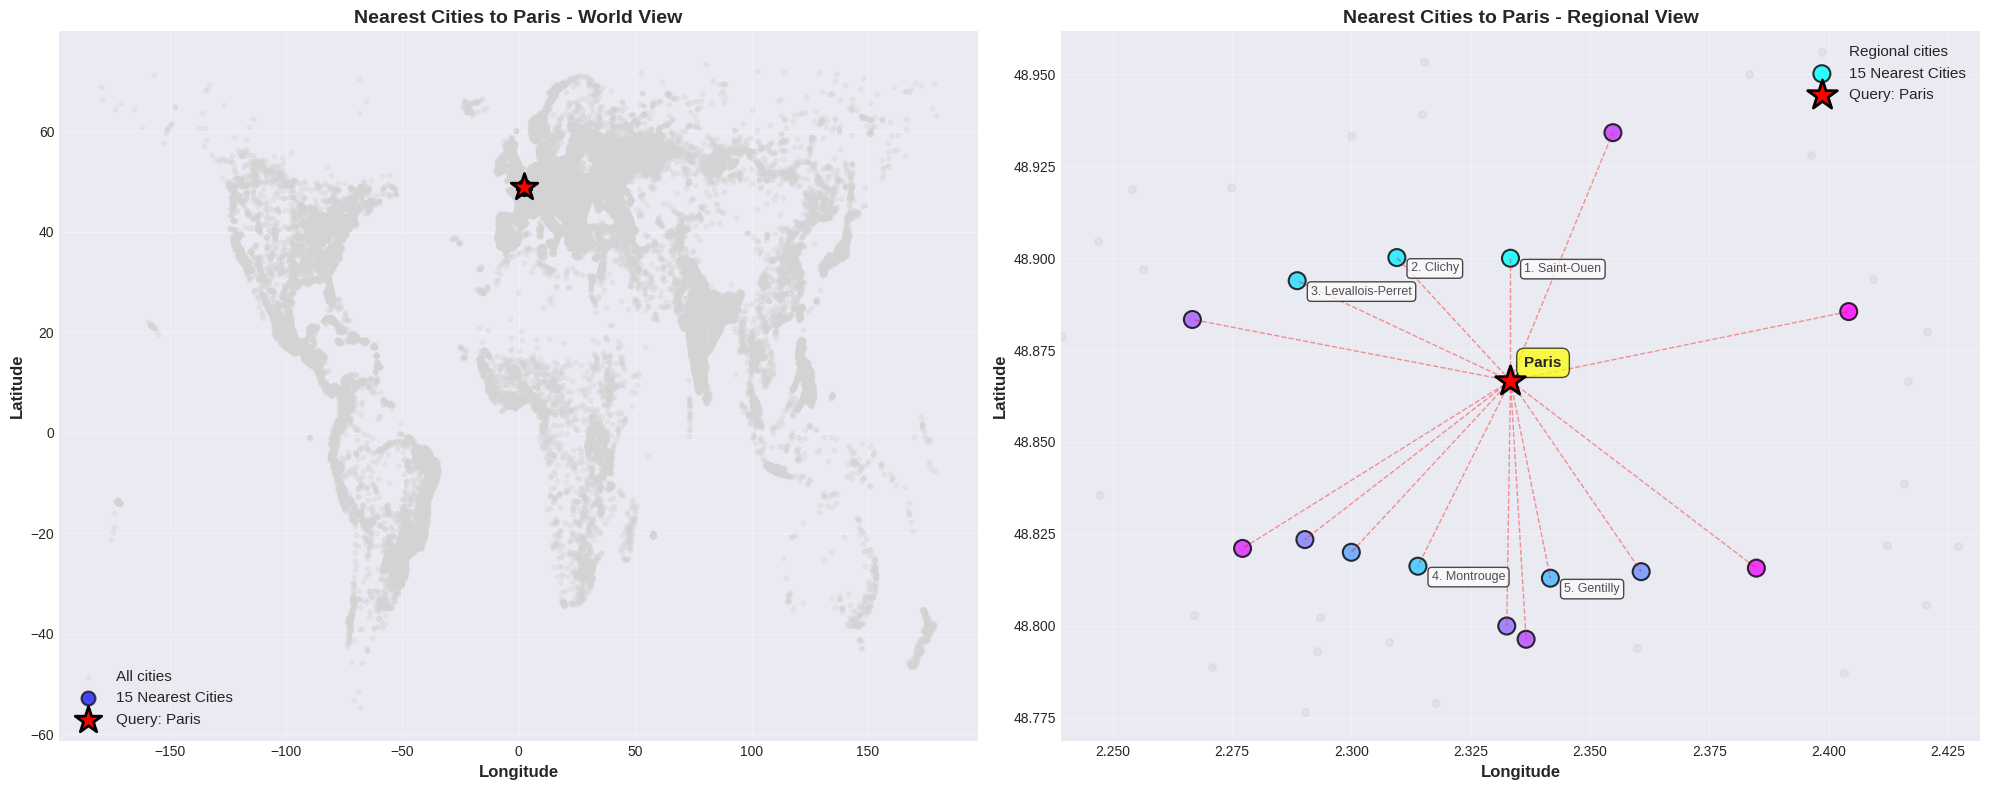


✓ Map visualization complete!


In [ ]:
# Cell 17: Visualize Nearest Cities on Map

def visualize_nearest_cities_map(city_name, k=10):
    """Visualize query city and its k nearest neighbors on a map"""
    result = find_nearest_cities(city_name, k, df_cities)

    if result is None:
        return

    query_city, nearest_cities = result

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: World view
    axes[0].scatter(df_cities['longitude'], df_cities['latitude'],
                   c='lightgray', s=10, alpha=0.3, label='All cities')
    axes[0].scatter(nearest_cities['longitude'], nearest_cities['latitude'],
                   c='blue', s=100, alpha=0.7, edgecolors='black',
                   linewidth=1.5, label=f'{k} Nearest Cities')
    axes[0].scatter(query_city['longitude'], query_city['latitude'],
                   c='red', s=400, marker='*', edgecolors='black',
                   linewidth=2, label=f'Query: {query_city["city"]}', zorder=5)

    # Draw lines to nearest cities
    for _, city in nearest_cities.iterrows():
        axes[0].plot([query_city['longitude'], city['longitude']],
                    [query_city['latitude'], city['latitude']],
                    'r--', alpha=0.3, linewidth=1)

    axes[0].set_xlabel('Longitude', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Latitude', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Nearest Cities to {query_city["city"]} - World View',
                     fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11, loc='best')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Regional zoom
    # Calculate bounds for zoom
    all_lats = np.concatenate([[query_city['latitude']], nearest_cities['latitude'].values])
    all_lons = np.concatenate([[query_city['longitude']], nearest_cities['longitude'].values])
    lat_margin = (all_lats.max() - all_lats.min()) * 0.2
    lon_margin = (all_lons.max() - all_lons.min()) * 0.2

    # Filter cities in region
    regional_cities = df_cities[
        (df_cities['latitude'] >= all_lats.min() - lat_margin) &
        (df_cities['latitude'] <= all_lats.max() + lat_margin) &
        (df_cities['longitude'] >= all_lons.min() - lon_margin) &
        (df_cities['longitude'] <= all_lons.max() + lon_margin)
    ]

    axes[1].scatter(regional_cities['longitude'], regional_cities['latitude'],
                   c='lightgray', s=30, alpha=0.4, label='Regional cities')
    axes[1].scatter(nearest_cities['longitude'], nearest_cities['latitude'],
                   c=range(len(nearest_cities)), cmap='cool', s=150,
                   alpha=0.8, edgecolors='black', linewidth=1.5,
                   label=f'{k} Nearest Cities')
    axes[1].scatter(query_city['longitude'], query_city['latitude'],
                   c='red', s=500, marker='*', edgecolors='black',
                   linewidth=2, label=f'Query: {query_city["city"]}', zorder=5)

    # Annotate cities
    axes[1].annotate(query_city['city'],
                    (query_city['longitude'], query_city['latitude']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    for i, (_, city) in enumerate(nearest_cities.head(5).iterrows(), 1):
        axes[1].annotate(f"{i}. {city['city']}",
                        (city['longitude'], city['latitude']),
                        xytext=(10, -10), textcoords='offset points',
                        fontsize=9, alpha=0.8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    # Draw circles showing distances
    for _, city in nearest_cities.iterrows():
        axes[1].plot([query_city['longitude'], city['longitude']],
                    [query_city['latitude'], city['latitude']],
                    'r--', alpha=0.4, linewidth=1)

    axes[1].set_xlabel('Longitude', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Latitude', fontsize=12, fontweight='bold')
    axes[1].set_title(f'Nearest Cities to {query_city["city"]} - Regional View',
                     fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11, loc='best')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(all_lons.min() - lon_margin, all_lons.max() + lon_margin)
    axes[1].set_ylim(all_lats.min() - lat_margin, all_lats.max() + lat_margin)

    plt.tight_layout()
    return fig

# Test visualization
if df_cities is not None:
    test_city = 'Paris'
    print(f"Creating map visualization for {test_city}...\n")
    fig = visualize_nearest_cities_map(test_city, k=15)
    plt.savefig(f'nearest_cities_{test_city.lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✓ Map visualization complete!")
else:
    print("Dataset not loaded - cannot create visualization")

In [ ]:
# Cell 18: Interactive City Finder

def interactive_city_finder():
    """Interactive function to find nearest cities"""
    if df_cities is None:
        print("Dataset not loaded!")
        return

    print("="*80)
    print("INTERACTIVE CITY FINDER")
    print("="*80)
    print(f"Total cities in database: {len(df_cities):,}")
    print("\nAvailable continents:")
    for continent in df_cities['continent'].unique():
        count = len(df_cities[df_cities['continent'] == continent])
        print(f"  - {continent}: {count} cities")

    print("\n" + "-"*80)
    city_name = input("Enter city name: ").strip()

    try:
        k = int(input("Enter number of nearest cities to find (default=10): ") or "10")
    except:
        k = 10

    print("\n" + "="*80)

    # Find and visualize
    fig = visualize_nearest_cities_map(city_name, k)
    if fig is not None:
        plt.savefig(f'nearest_cities_{city_name.lower().replace(" ", "_")}.png',
                   dpi=150, bbox_inches='tight')
        plt.show()

# Run interactive finder
if df_cities is not None:
    print("\nRun this cell and enter a city name when prompted!")
    print("Example cities: Tokyo, London, Cairo, Mumbai, Rio de Janeiro, Moscow")
else:
    print("Load the dataset first!")


Run this cell and enter a city name when prompted!
Example cities: Tokyo, London, Cairo, Mumbai, Rio de Janeiro, Moscow


In [ ]:
# Cell 19: Load Classic Datasets for Comparison

# Load classic datasets
classic_datasets = []

# Iris dataset
iris = load_iris()
classic_datasets.append({
    'name': 'Iris',
    'X': iris.data,
    'y': iris.target,
    'feature_names': iris.feature_names,
    'target_names': iris.target_names
})

# Wine dataset
wine = load_wine()
classic_datasets.append({
    'name': 'Wine',
    'X': wine.data,
    'y': wine.target,
    'feature_names': wine.feature_names,
    'target_names': wine.target_names
})

# Breast Cancer dataset
cancer = load_breast_cancer()
classic_datasets.append({
    'name': 'Breast Cancer',
    'X': cancer.data,
    'y': cancer.target,
    'feature_names': cancer.feature_names,
    'target_names': cancer.target_names
})

# Display dataset information
print("="*80)
print("CLASSIC DATASETS LOADED")
print("="*80)

for ds in classic_datasets:
    print(f"\n{ds['name']} Dataset:")
    print(f"  Samples: {ds['X'].shape[0]}")
    print(f"  Features: {ds['X'].shape[1]}")
    print(f"  Classes: {len(np.unique(ds['y']))}")
    print(f"  Class distribution: {dict(zip(*np.unique(ds['y'], return_counts=True)))}")


CLASSIC DATASETS LOADED

Iris Dataset:
  Samples: 150
  Features: 4
  Classes: 3
  Class distribution: {np.int64(0): np.int64(50), np.int64(1): np.int64(50), np.int64(2): np.int64(50)}

Wine Dataset:
  Samples: 178
  Features: 13
  Classes: 3
  Class distribution: {np.int64(0): np.int64(59), np.int64(1): np.int64(71), np.int64(2): np.int64(48)}

Breast Cancer Dataset:
  Samples: 569
  Features: 30
  Classes: 2
  Class distribution: {np.int64(0): np.int64(212), np.int64(1): np.int64(357)}


In [ ]:
# Cell 20: Comprehensive Performance Benchmark

def benchmark_all_algorithms(datasets, k=5, n_runs=5):
    """Comprehensive benchmark of all algorithms"""
    results_table = []

    for ds in datasets:
        print(f"\n{'='*80}")
        print(f"Benchmarking on {ds['name']} dataset")
        print(f"{'='*80}")

        X, y = ds['X'], ds['y']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        dataset_results = {'dataset': ds['name'], 'samples': len(X), 'features': X.shape[1]}

        # 1. Python K-D Tree
        print("  Testing Python K-D Tree...")
        times = []
        for _ in range(n_runs):
            start = time.time()
            py_tree = KDTree()
            py_tree.build(X_train_scaled, y_train)
            py_pred = np.array([py_tree.predict(x, k) for x in X_test_scaled])
            times.append(time.time() - start)
        dataset_results['Python_KDTree_time'] = np.mean(times)
        dataset_results['Python_KDTree_std'] = np.std(times)
        dataset_results['Python_KDTree_acc'] = np.mean(py_pred == y_test)

        # 2. C++ K-D Tree (if available)
        if kdtree_cpp is not None:
            print("  Testing C++ K-D Tree...")
            try:
                times = []
                for _ in range(n_runs):
                    start = time.time()
                    cpp_tree = kdtree_cpp.KDTreeCpp()
                    cpp_tree.build(X_train_scaled.astype(np.float64), y_train.astype(np.int32))
                    cpp_pred = np.array([cpp_tree.predict(x.astype(np.float64), k) for x in X_test_scaled])
                    times.append(time.time() - start)
                dataset_results['CPP_KDTree_time'] = np.mean(times)
                dataset_results['CPP_KDTree_std'] = np.std(times)
                dataset_results['CPP_KDTree_acc'] = np.mean(cpp_pred == y_test)
            except Exception as e:
                print(f"    C++ failed: {e}")
                dataset_results['CPP_KDTree_time'] = np.nan
                dataset_results['CPP_KDTree_std'] = np.nan
                dataset_results['CPP_KDTree_acc'] = np.nan

        # 3. Brute Force
        print("  Testing Brute Force...")
        times = []
        for _ in range(n_runs):
            start = time.time()
            brute = BruteForceKNN()
            brute.fit(X_train_scaled, y_train)
            brute_pred = brute.predict(X_test_scaled, k)
            times.append(time.time() - start)
        dataset_results['BruteForce_time'] = np.mean(times)
        dataset_results['BruteForce_std'] = np.std(times)
        dataset_results['BruteForce_acc'] = np.mean(brute_pred == y_test)

        # 4. Scikit-learn
        print("  Testing Scikit-learn...")
        times = []
        for _ in range(n_runs):
            start = time.time()
            sklearn_knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
            sklearn_knn.fit(X_train_scaled, y_train)
            sklearn_pred = sklearn_knn.predict(X_test_scaled)
            times.append(time.time() - start)
        dataset_results['Sklearn_time'] = np.mean(times)
        dataset_results['Sklearn_std'] = np.std(times)
        dataset_results['Sklearn_acc'] = np.mean(sklearn_pred == y_test)

        results_table.append(dataset_results)

    return pd.DataFrame(results_table)

# Run comprehensive benchmark
print("Starting comprehensive benchmark...")
print("This may take a few minutes...\n")

benchmark_df = benchmark_all_algorithms(classic_datasets, k=5, n_runs=3)

print("\n" + "="*80)
print("BENCHMARK RESULTS")
print("="*80)
display(benchmark_df)

Starting comprehensive benchmark...
This may take a few minutes...


Benchmarking on Iris dataset
  Testing Python K-D Tree...
  Testing C++ K-D Tree...
  Testing Brute Force...
  Testing Scikit-learn...

Benchmarking on Wine dataset
  Testing Python K-D Tree...
  Testing C++ K-D Tree...
  Testing Brute Force...
  Testing Scikit-learn...

Benchmarking on Breast Cancer dataset
  Testing Python K-D Tree...
  Testing C++ K-D Tree...
  Testing Brute Force...
  Testing Scikit-learn...

BENCHMARK RESULTS


dataset  samples  features  Python_KDTree_time  Python_KDTree_std  \
0           Iris      150         4            0.062352           0.014886   
1           Wine      178        13            0.100539           0.012899   
2  Breast Cancer      569        30            1.003249           0.026602   

   Python_KDTree_acc  CPP_KDTree_time  CPP_KDTree_std  CPP_KDTree_acc  \
0           1.000000         0.000659        0.000095        1.000000   
1           0.962963         0.001235        0.000132        0.962963   
2           0.959064         0.009304        0.000222        0.959064   

   BruteForce_time  BruteForce_std  BruteForce_acc  Sklearn_time  Sklearn_std  \
0         0.068180        0.012197        1.000000      0.005038     0.000573   
1         0.091287        0.001839        0.962963      0.004037     0.000314   
2         0.805339        0.016417        0.959064      0.010507     0.000545   

   Sklearn_acc  
0     1.000000  
1     0.962963  
2     0.959064

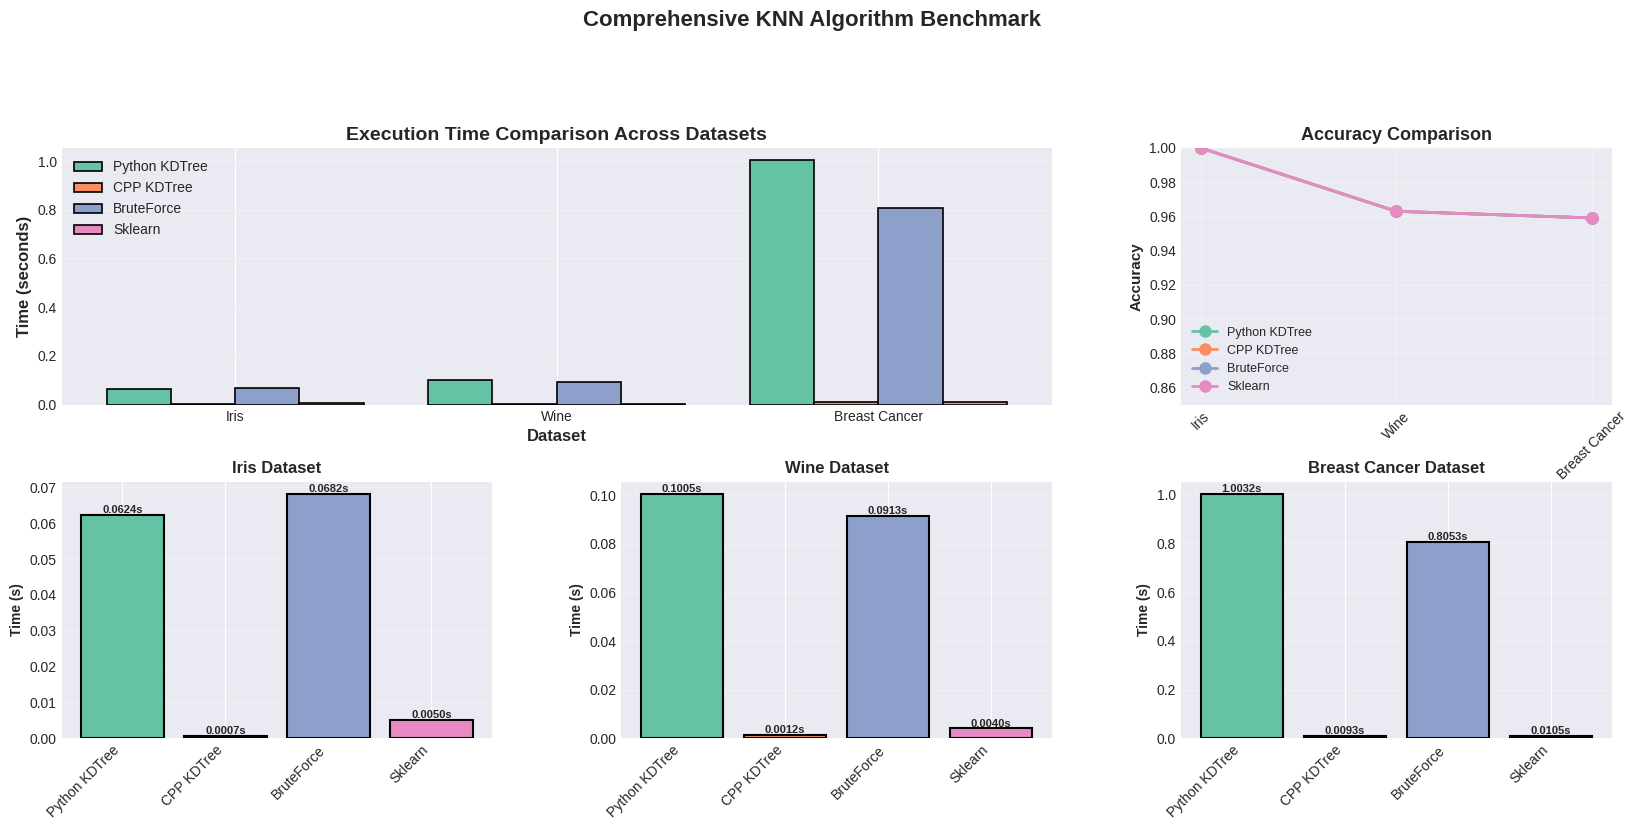

In [ ]:
# Cell 21: Visualize Benchmark Results

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Extract data for plotting
algorithms = ['Python_KDTree', 'BruteForce', 'Sklearn']
if 'CPP_KDTree_time' in benchmark_df.columns and not benchmark_df['CPP_KDTree_time'].isna().all():
    algorithms.insert(1, 'CPP_KDTree')

colors = plt.cm.Set2(range(len(algorithms)))
dataset_names = benchmark_df['dataset'].values

# Plot 1: Execution Time Comparison (Bar chart)
ax1 = fig.add_subplot(gs[0, :2])
x = np.arange(len(dataset_names))
width = 0.2
for i, alg in enumerate(algorithms):
    times = benchmark_df[f'{alg}_time'].values
    ax1.bar(x + i*width, times, width, label=alg.replace('_', ' '),
           color=colors[i], edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Execution Time Comparison Across Datasets', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticks(x + width * (len(algorithms)-1)/2)
ax1.set_xticklabels(dataset_names)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Accuracy Comparison
ax2 = fig.add_subplot(gs[0, 2])
for i, alg in enumerate(algorithms):
    accs = benchmark_df[f'{alg}_acc'].values
    ax2.plot(dataset_names, accs, marker='o', linewidth=2,
            markersize=8, label=alg.replace('_', ' '), color=colors[i])
ax2.set_xlabel('Dataset', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
ax2.set_ylim([0.85, 1.0])
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3-5: Individual dataset comparisons
for idx, dataset_name in enumerate(dataset_names):
    ax = fig.add_subplot(gs[1 + idx//3, idx%3])

    dataset_row = benchmark_df[benchmark_df['dataset'] == dataset_name].iloc[0]
    times = [dataset_row[f'{alg}_time'] for alg in algorithms]

    bars = ax.bar(range(len(algorithms)), times, color=colors,
                  edgecolor='black', linewidth=1.5)
    ax.set_xticks(range(len(algorithms)))
    ax.set_xticklabels([alg.replace('_', ' ') for alg in algorithms],
                       rotation=45, ha='right')
    ax.set_ylabel('Time (s)', fontsize=10, fontweight='bold')
    ax.set_title(f'{dataset_name} Dataset', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{time_val:.4f}s',
               ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.suptitle('Comprehensive KNN Algorithm Benchmark',
            fontsize=16, fontweight='bold', y=0.995)
plt.savefig('comprehensive_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()


Generating decision boundary visualizations for classic datasets...
This may take a few minutes...

Processing Iris dataset...
  Creating boundary for Python K-D Tree...
  Creating boundary for Brute Force...
  Creating boundary for Scikit-learn (kd_tree)...
  Creating boundary for Scikit-learn (brute)...


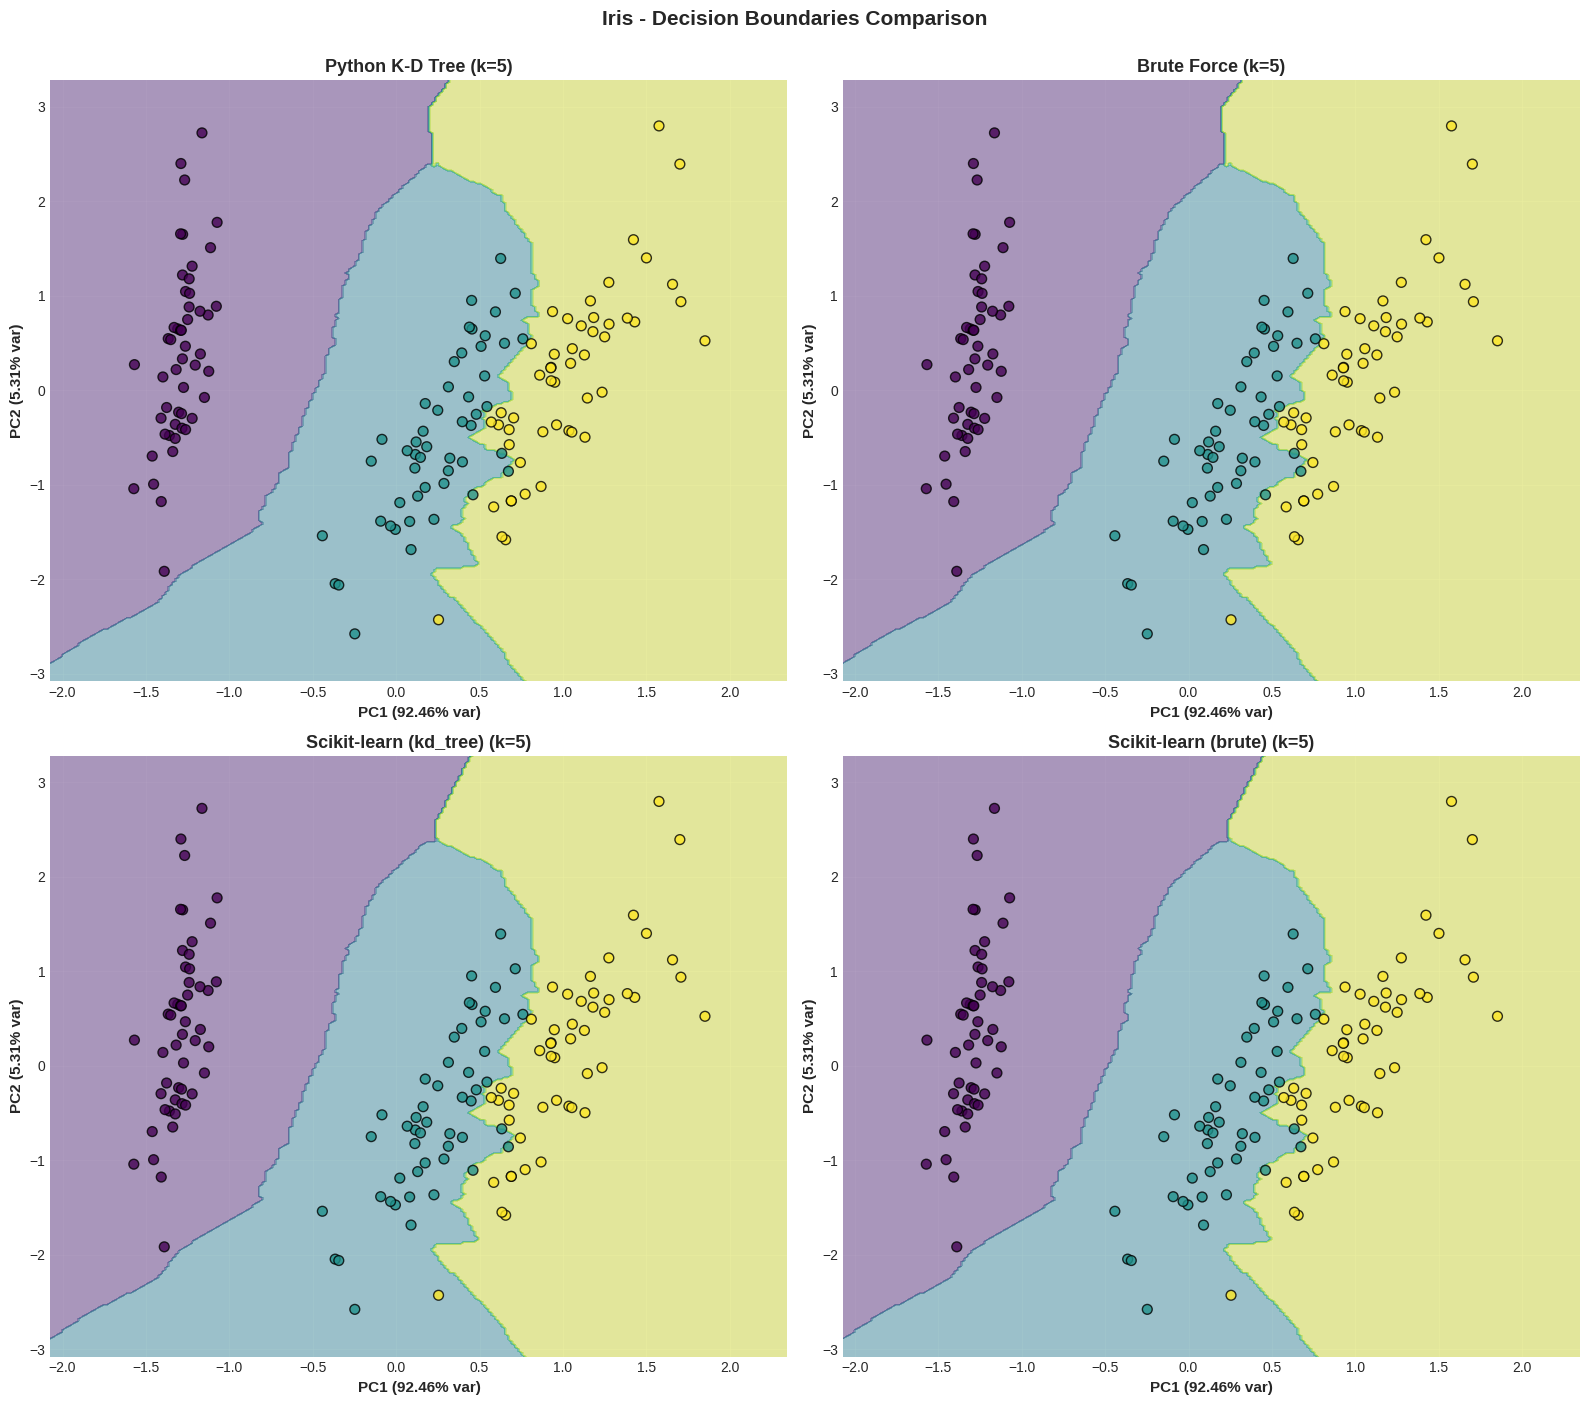


Processing Wine dataset...
  Creating boundary for Python K-D Tree...
  Creating boundary for Brute Force...
  Creating boundary for Scikit-learn (kd_tree)...
  Creating boundary for Scikit-learn (brute)...


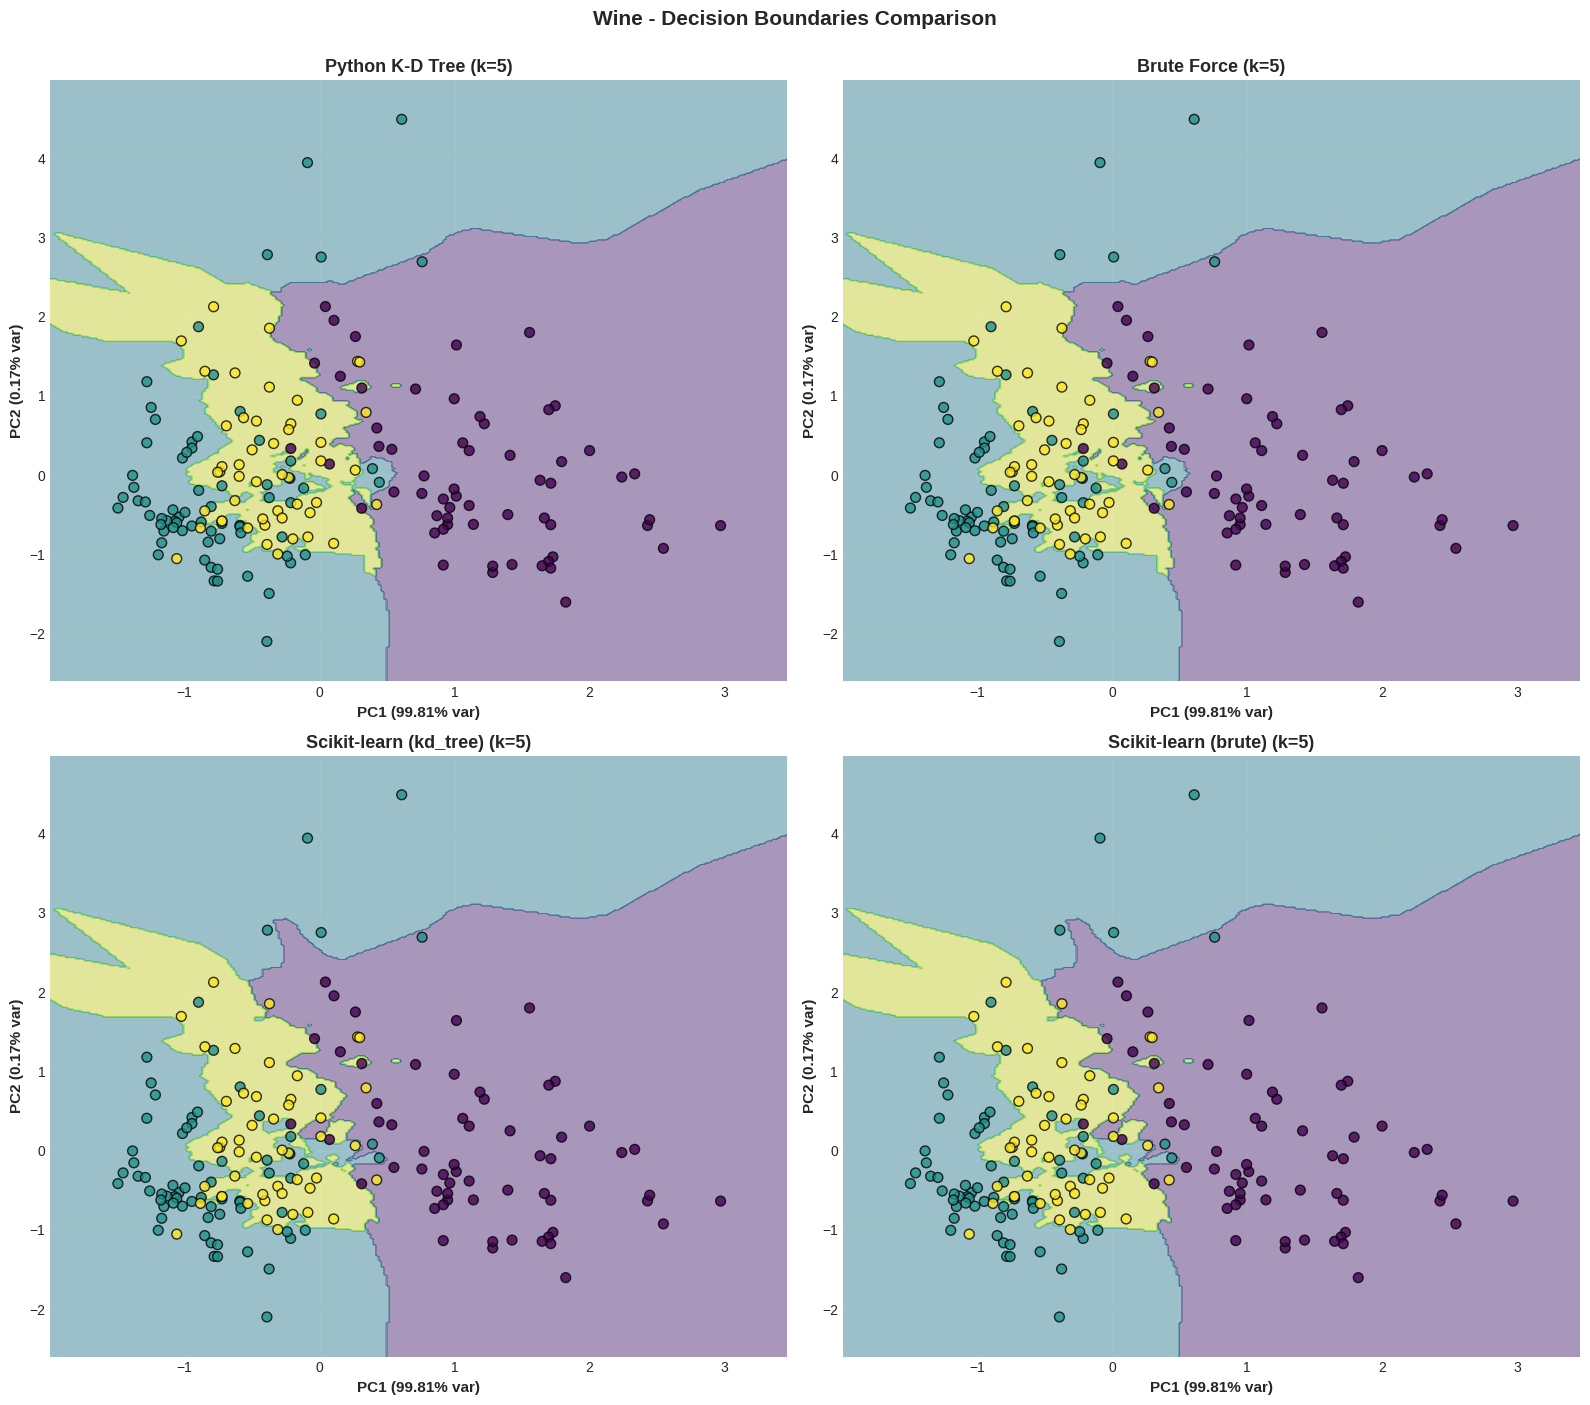


Processing Breast Cancer dataset...
  Creating boundary for Python K-D Tree...
  Creating boundary for Brute Force...


KeyboardInterrupt: 

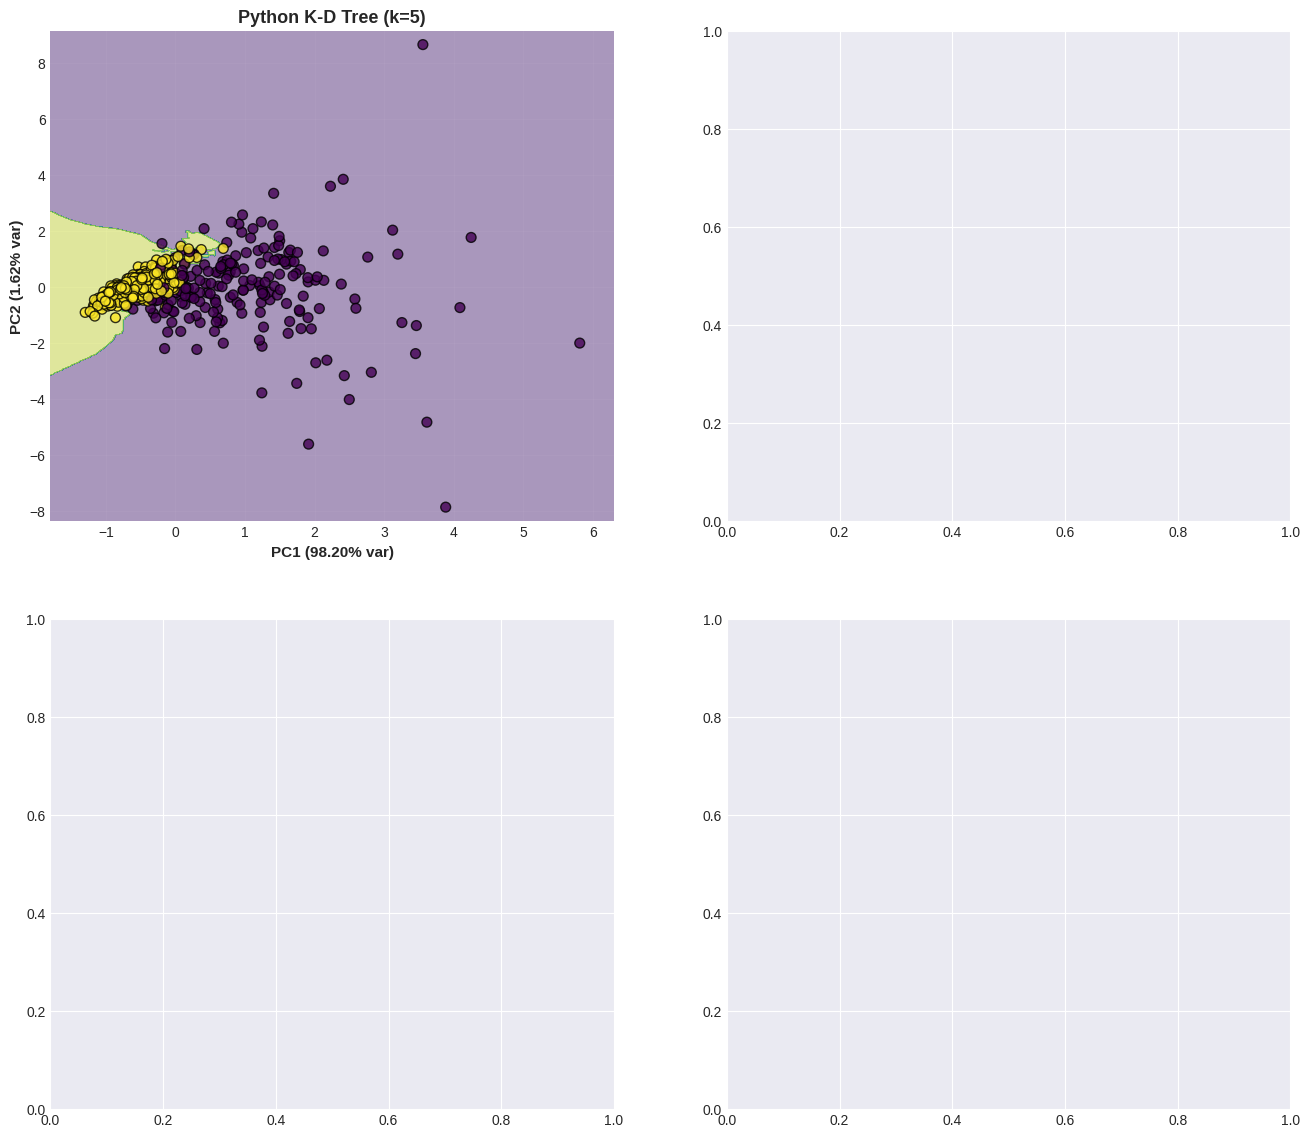

In [ ]:
# Cell 22: Decision Boundaries on Classic Datasets

def plot_2d_decision_boundary(X, y, title, k=5):
    """Plot decision boundaries using first 2 principal components"""
    from sklearn.decomposition import PCA

    # If more than 2 features, use PCA
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        explained_var = pca.explained_variance_ratio_
        xlabel = f'PC1 ({explained_var[0]:.2%} var)'
        ylabel = f'PC2 ({explained_var[1]:.2%} var)'
    else:
        X_2d = X
        xlabel = 'Feature 1'
        ylabel = 'Feature 2'

    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_2d)

    # Create mesh
    h = 0.02
    x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
    y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()

    classifiers = [
        ('Python K-D Tree', KDTree),
        ('Brute Force', BruteForceKNN),
        ('Scikit-learn (kd_tree)', KNeighborsClassifier),
        ('Scikit-learn (brute)', KNeighborsClassifier)
    ]

    for idx, (name, clf_class) in enumerate(classifiers):
        print(f"  Creating boundary for {name}...")

        if clf_class == KDTree:
            clf = KDTree()
            clf.build(X_scaled, y)
            Z = np.array([clf.predict(np.array([x, y_val]), k)
                         for x, y_val in zip(xx.ravel(), yy.ravel())])
        elif clf_class == BruteForceKNN:
            clf = BruteForceKNN()
            clf.fit(X_scaled, y)
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()], k)
        else:
            if 'brute' in name:
                clf = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
            else:
                clf = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
            clf.fit(X_scaled, y)
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        Z = Z.reshape(xx.shape)

        # Plot
        axes[idx].contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
        scatter = axes[idx].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y,
                                   cmap='viridis', s=50, edgecolors='black',
                                   linewidth=1, alpha=0.8)
        axes[idx].set_xlabel(xlabel, fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(ylabel, fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{name} (k={k})', fontsize=13, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle(f'{title} - Decision Boundaries Comparison',
                fontsize=15, fontweight='bold', y=1.0)
    plt.tight_layout()
    return fig

# Create decision boundary visualizations for each dataset
print("\nGenerating decision boundary visualizations for classic datasets...")
print("This may take a few minutes...\n")

for ds in classic_datasets:
    print(f"Processing {ds['name']} dataset...")
    fig = plot_2d_decision_boundary(ds['X'], ds['y'], ds['name'], k=5)
    plt.savefig(f"boundaries_{ds['name'].lower().replace(' ', '_')}.png",
               dpi=150, bbox_inches='tight')
    plt.show()
    print()

In [ ]:
# Cell 23: Scalability Analysis - How algorithms scale with dataset size

def analyze_scalability(n_samples_list=[100, 500, 1000, 2000, 5000], n_features=10, k=5):
    """Analyze how algorithms scale with dataset size"""
    results = {alg: {'build': [], 'query': [], 'total': []}
              for alg in ['Python_KDTree', 'BruteForce', 'Sklearn']}

    if kdtree_cpp is not None:
        results['CPP_KDTree'] = {'build': [], 'query': [], 'total': []}

    for n_samples in n_samples_list:
        print(f"\nTesting with {n_samples} samples...")

        # Generate data
        X, y = make_classification(n_samples=n_samples, n_features=n_features,
                                   n_informative=n_features//2, n_redundant=0,
                                   n_classes=3, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Python K-D Tree
        start = time.time()
        py_tree = KDTree()
        py_tree.build(X_train, y_train)
        build_time = time.time() - start

        start = time.time()
        _ = [py_tree.predict(x, k) for x in X_test]
        query_time = time.time() - start

        results['Python_KDTree']['build'].append(build_time)
        results['Python_KDTree']['query'].append(query_time)
        results['Python_KDTree']['total'].append(build_time + query_time)

        # C++ K-D Tree
        if kdtree_cpp is not None:
            try:
                start = time.time()
                cpp_tree = kdtree_cpp.KDTreeCpp()
                cpp_tree.build(X_train.astype(np.float64), y_train.astype(np.int32))
                build_time = time.time() - start

                start = time.time()
                _ = [cpp_tree.predict(x.astype(np.float64), k) for x in X_test]
                query_time = time.time() - start

                results['CPP_KDTree']['build'].append(build_time)
                results['CPP_KDTree']['query'].append(query_time)
                results['CPP_KDTree']['total'].append(build_time + query_time)
            except:
                pass

        # Brute Force
        start = time.time()
        brute = BruteForceKNN()
        brute.fit(X_train, y_train)
        _ = brute.predict(X_test, k)
        total_time = time.time() - start

        results['BruteForce']['build'].append(0)
        results['BruteForce']['query'].append(total_time)
        results['BruteForce']['total'].append(total_time)

        # Scikit-learn
        start = time.time()
        sklearn_knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
        sklearn_knn.fit(X_train, y_train)
        _ = sklearn_knn.predict(X_test)
        total_time = time.time() - start

        results['Sklearn']['build'].append(0)
        results['Sklearn']['query'].append(total_time)
        results['Sklearn']['total'].append(total_time)

    return results, n_samples_list

# Run scalability analysis
print("="*80)
print("SCALABILITY ANALYSIS")
print("="*80)
print("Testing how algorithms scale with increasing dataset size...")

scalability_results, sample_sizes = analyze_scalability(
    n_samples_list=[100, 500, 1000, 2500, 5000],
    n_features=10,
    k=5
)

SCALABILITY ANALYSIS
Testing how algorithms scale with increasing dataset size...

Testing with 100 samples...

Testing with 500 samples...

Testing with 1000 samples...

Testing with 2500 samples...

Testing with 5000 samples...


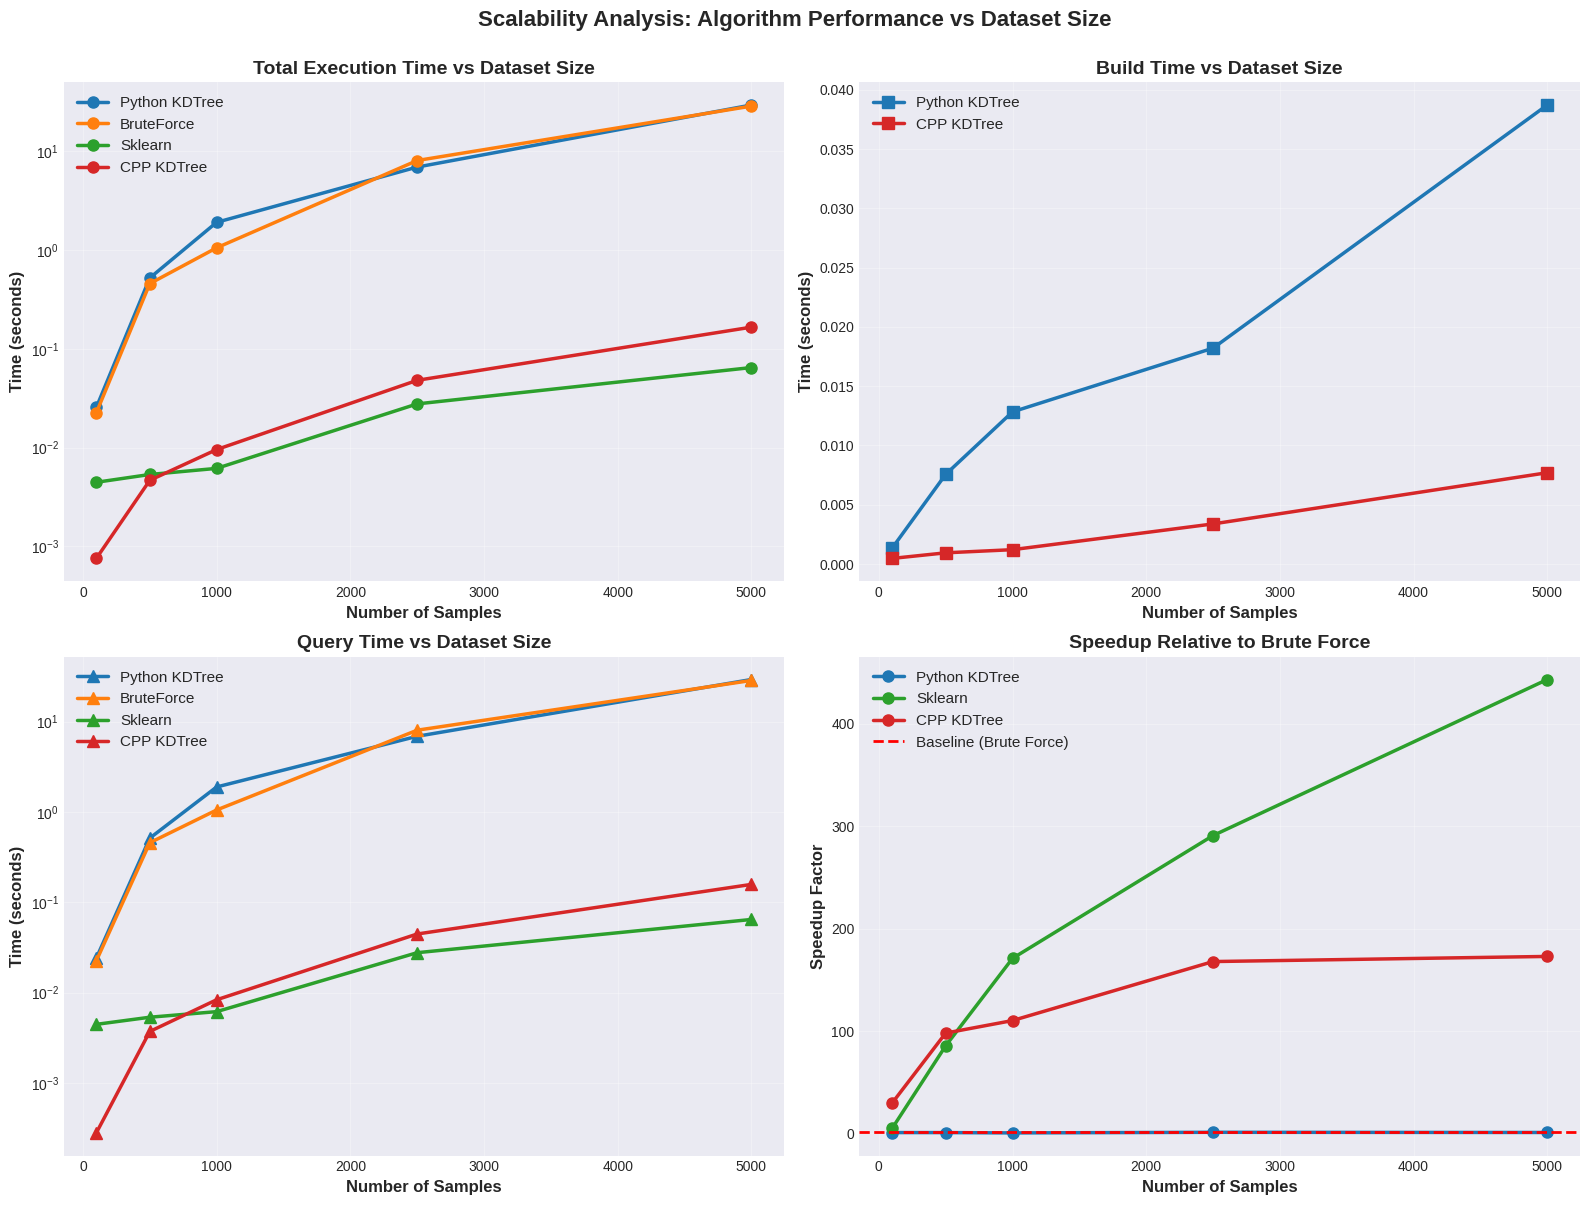


SCALABILITY SUMMARY

For 5000 samples:
  Python KDTree: 29.3456s (speedup: 0.97x)
  BruteForce: 28.6065s (speedup: 1.00x)
  Sklearn: 0.0645s (speedup: 443.41x)
  CPP KDTree: 0.1654s (speedup: 172.93x)


In [ ]:
# Cell 24: Visualize Scalability Results

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

algorithms = list(scalability_results.keys())
colors = plt.cm.tab10(range(len(algorithms)))

# Plot 1: Total Time vs Dataset Size
axes[0, 0].set_title('Total Execution Time vs Dataset Size', fontsize=14, fontweight='bold')
for i, alg in enumerate(algorithms):
    axes[0, 0].plot(sample_sizes, scalability_results[alg]['total'],
                   marker='o', linewidth=2.5, markersize=8,
                   label=alg.replace('_', ' '), color=colors[i])
axes[0, 0].set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Plot 2: Build Time vs Dataset Size
axes[0, 1].set_title('Build Time vs Dataset Size', fontsize=14, fontweight='bold')
for i, alg in enumerate(algorithms):
    if any(scalability_results[alg]['build']):
        axes[0, 1].plot(sample_sizes, scalability_results[alg]['build'],
                       marker='s', linewidth=2.5, markersize=8,
                       label=alg.replace('_', ' '), color=colors[i])
axes[0, 1].set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Query Time vs Dataset Size
axes[1, 0].set_title('Query Time vs Dataset Size', fontsize=14, fontweight='bold')
for i, alg in enumerate(algorithms):
    axes[1, 0].plot(sample_sizes, scalability_results[alg]['query'],
                   marker='^', linewidth=2.5, markersize=8,
                   label=alg.replace('_', ' '), color=colors[i])
axes[1, 0].set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Plot 4: Speedup comparison (normalized to brute force)
axes[1, 1].set_title('Speedup Relative to Brute Force', fontsize=14, fontweight='bold')
brute_times = scalability_results['BruteForce']['total']
for i, alg in enumerate(algorithms):
    if alg != 'BruteForce':
        speedups = [b / t if t > 0 else 0
                   for b, t in zip(brute_times, scalability_results[alg]['total'])]
        axes[1, 1].plot(sample_sizes, speedups,
                       marker='o', linewidth=2.5, markersize=8,
                       label=alg.replace('_', ' '), color=colors[i])
axes[1, 1].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (Brute Force)')
axes[1, 1].set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Scalability Analysis: Algorithm Performance vs Dataset Size',
            fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig('scalability_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SCALABILITY SUMMARY")
print("="*80)
print(f"\nFor {sample_sizes[-1]} samples:")
for alg in algorithms:
    total_time = scalability_results[alg]['total'][-1]
    speedup = brute_times[-1] / total_time if total_time > 0 else 0
    print(f"  {alg.replace('_', ' ')}: {total_time:.4f}s (speedup: {speedup:.2f}x)")

Creating 3D visualization of K-NN...


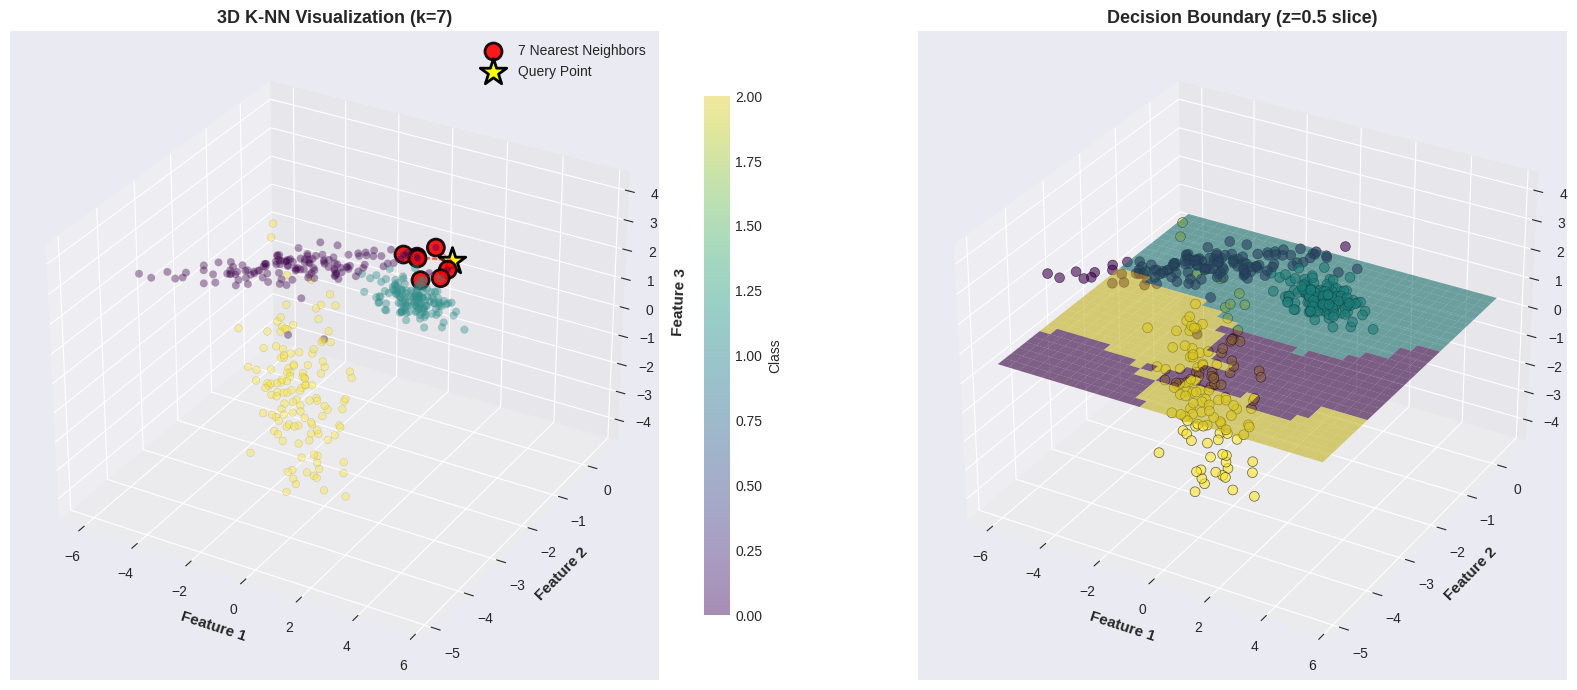

✓ 3D visualization complete!


In [ ]:
# Cell 25: 3D Visualization of KNN

def visualize_knn_3d(n_samples=300, k=5):
    """Create 3D visualization of KNN classification"""
    # Generate 3D data
    X, y = make_classification(n_samples=n_samples, n_features=3, n_informative=3,
                               n_redundant=0, n_classes=3, n_clusters_per_class=1,
                               class_sep=2.0, random_state=42)

    # Build K-D tree
    tree = KDTree()
    tree.build(X, y)

    # Select a query point
    query_point = np.array([0.5, 0.5, 0.5])
    neighbors = tree.query(query_point, k)
    neighbor_points = np.array([point for point, _ in neighbors])

    # Create 3D plot
    fig = plt.figure(figsize=(18, 7))

    # Plot 1: Full dataset with neighbors highlighted
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis',
                          s=30, alpha=0.4, edgecolors='gray', linewidth=0.3)
    ax1.scatter(neighbor_points[:, 0], neighbor_points[:, 1], neighbor_points[:, 2],
               s=150, c='red', marker='o', edgecolors='black', linewidth=2,
               label=f'{k} Nearest Neighbors', alpha=0.9)
    ax1.scatter(query_point[0], query_point[1], query_point[2],
               s=400, c='yellow', marker='*', edgecolors='black', linewidth=2,
               label='Query Point', zorder=10)

    # Draw lines to neighbors
    for point in neighbor_points:
        ax1.plot([query_point[0], point[0]],
                [query_point[1], point[1]],
                [query_point[2], point[2]],
                'r--', alpha=0.4, linewidth=1)

    ax1.set_xlabel('Feature 1', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Feature 2', fontsize=11, fontweight='bold')
    ax1.set_zlabel('Feature 3', fontsize=11, fontweight='bold')
    ax1.set_title(f'3D K-NN Visualization (k={k})', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    plt.colorbar(scatter1, ax=ax1, label='Class', shrink=0.8)

    # Plot 2: Decision boundaries (slice through z=0.5)
    ax2 = fig.add_subplot(122, projection='3d')

    # Create grid for visualization
    x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    xx, yy = np.meshgrid(x_range, y_range)
    zz = np.full_like(xx, 0.5)

    # Predict for grid points
    grid_predictions = []
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            point = np.array([xx[j, i], yy[j, i], zz[j, i]])
            pred = tree.predict(point, k)
            grid_predictions.append(pred)

    grid_predictions = np.array(grid_predictions).reshape(xx.shape)

    # Plot surface
    surf = ax2.plot_surface(xx, yy, zz, facecolors=plt.cm.viridis(grid_predictions/2),
                           alpha=0.6, edgecolor='none')

    # Plot data points
    ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis',
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

    ax2.set_xlabel('Feature 1', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Feature 2', fontsize=11, fontweight='bold')
    ax2.set_zlabel('Feature 3', fontsize=11, fontweight='bold')
    ax2.set_title('Decision Boundary (z=0.5 slice)', fontsize=13, fontweight='bold')

    plt.tight_layout()
    return fig

# Create 3D visualization
print("Creating 3D visualization of K-NN...")
fig = visualize_knn_3d(n_samples=400, k=7)
plt.savefig('knn_3d_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 3D visualization complete!")

Generating confusion matrices and classification reports...



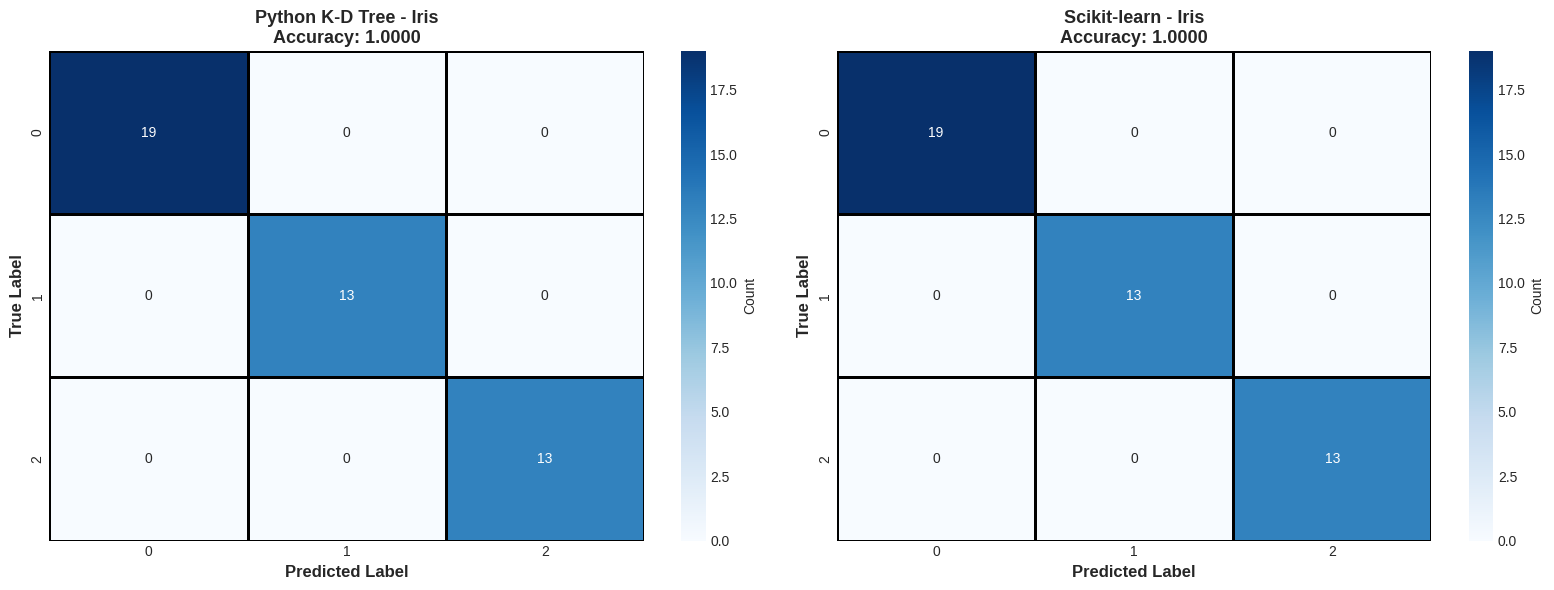


CLASSIFICATION REPORT - Iris

Python K-D Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

--------------------------------------------------------------------------------
Scikit-learn:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

--------------------------------------------------------------------------------


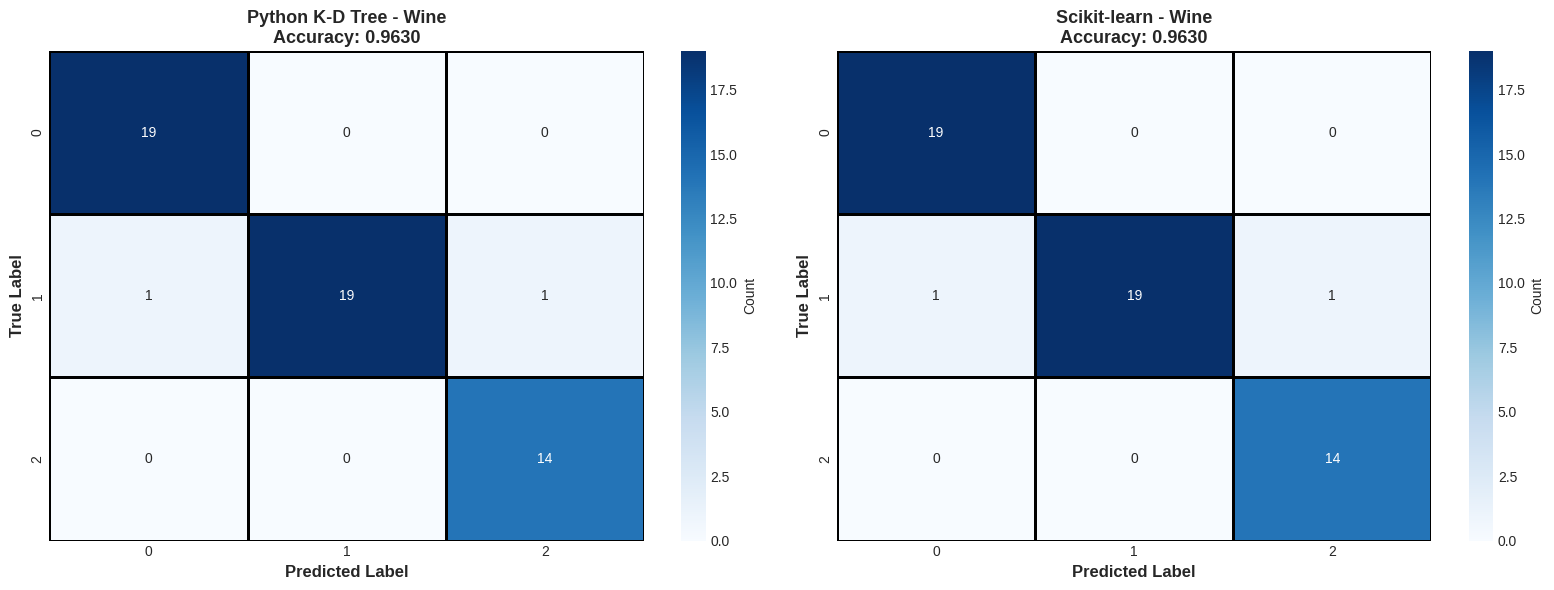


CLASSIFICATION REPORT - Wine

Python K-D Tree:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.90      0.95        21
           2       0.93      1.00      0.97        14

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54

--------------------------------------------------------------------------------
Scikit-learn:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.90      0.95        21
           2       0.93      1.00      0.97        14

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54

--------------------------------------------------------------------------------


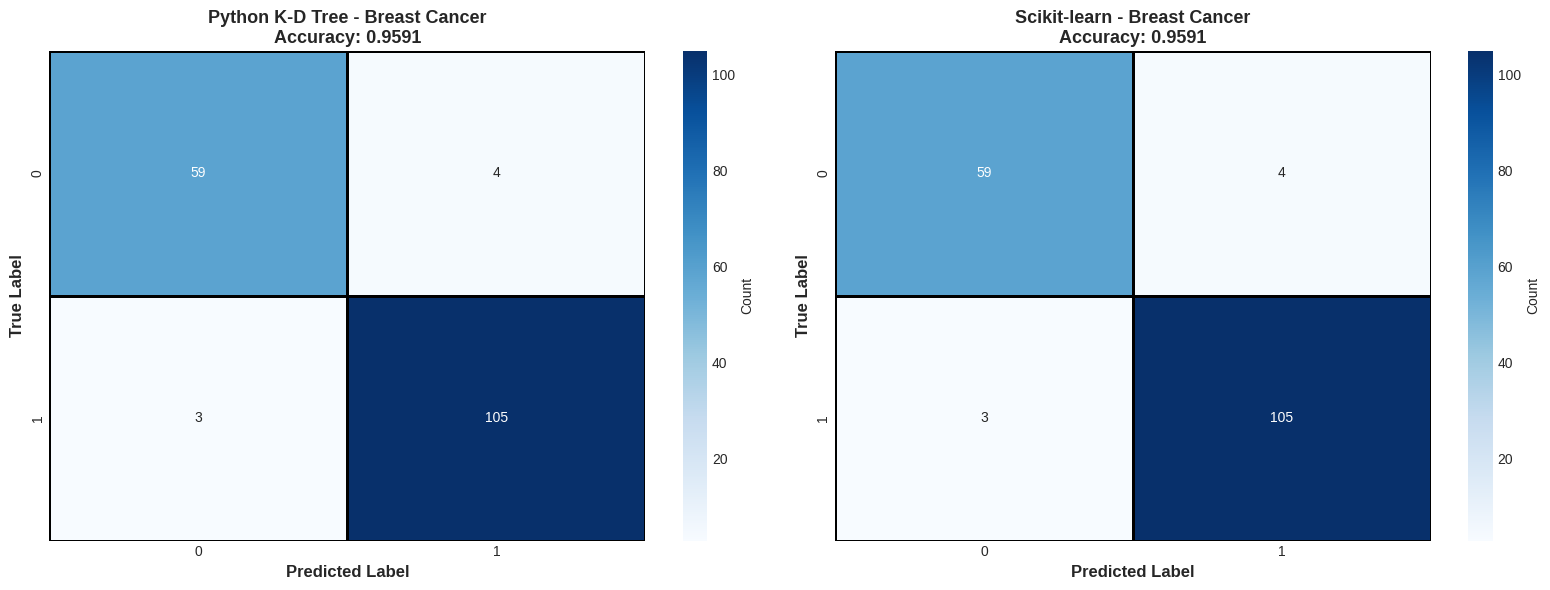


CLASSIFICATION REPORT - Breast Cancer

Python K-D Tree:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        63
           1       0.96      0.97      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

--------------------------------------------------------------------------------
Scikit-learn:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        63
           1       0.96      0.97      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

--------------------------------------------------------------------------------

✓ Evaluation complete!


In [ ]:
# Cell 26: Confusion Matrix and Classification Report

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_classifiers(X, y, dataset_name, k=5):
    """Generate confusion matrices and classification reports"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    classifiers = {
        'Python K-D Tree': None,
        'Scikit-learn': None
    }

    # Train classifiers
    py_tree = KDTree()
    py_tree.build(X_train_scaled, y_train)
    py_predictions = np.array([py_tree.predict(x, k) for x in X_test_scaled])
    classifiers['Python K-D Tree'] = py_predictions

    sklearn_knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    sklearn_knn.fit(X_train_scaled, y_train)
    sklearn_predictions = sklearn_knn.predict(X_test_scaled)
    classifiers['Scikit-learn'] = sklearn_predictions

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for idx, (name, predictions) in enumerate(classifiers.items()):
        cm = confusion_matrix(y_test, predictions)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   ax=axes[idx], cbar_kws={'label': 'Count'},
                   linewidths=1, linecolor='black')
        axes[idx].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label', fontsize=12, fontweight='bold')
        axes[idx].set_title(f'{name} - {dataset_name}\nAccuracy: {np.mean(predictions == y_test):.4f}',
                          fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png',
               dpi=150, bbox_inches='tight')
    plt.show()

    # Print classification reports
    print(f"\n{'='*80}")
    print(f"CLASSIFICATION REPORT - {dataset_name}")
    print(f"{'='*80}\n")

    for name, predictions in classifiers.items():
        print(f"{name}:")
        print(classification_report(y_test, predictions, zero_division=0))
        print("-"*80)

# Evaluate on all classic datasets
print("Generating confusion matrices and classification reports...\n")

for ds in classic_datasets:
    evaluate_classifiers(ds['X'], ds['y'], ds['name'], k=5)

print("\n✓ Evaluation complete!")

In [ ]:
# Cell 27: Summary Report and Final Statistics

print("="*80)
print(" "*20 + "COMPREHENSIVE K-D TREE KNN ANALYSIS")
print(" "*30 + "FINAL SUMMARY")
print("="*80)

print("\n📊 IMPLEMENTATIONS TESTED:")
print("-"*80)
print("1. ✓ Python K-D Tree (Custom Implementation)")
print("2. ✓ C++ K-D Tree (pybind11 Extension)" if kdtree_cpp else "2. ✗ C++ K-D Tree (Not Available)")
print("3. ✓ Brute Force KNN (Naive Implementation)")
print("4. ✓ Scikit-learn KNN (Library Implementation)")

print("\n📈 DATASETS ANALYZED:")
print("-"*80)
print(f"Synthetic Datasets: 4")
print(f"  - Linearly Separable (3 classes)")
print(f"  - Moons Dataset (2 classes)")
print(f"  - Concentric Circles (2 classes)")
print(f"  - Multi-class Complex (4 classes)")
print(f"\nClassic ML Datasets: {len(classic_datasets)}")
for ds in classic_datasets:
    print(f"  - {ds['name']}: {ds['X'].shape[0]} samples, {ds['X'].shape[1]} features, {len(np.unique(ds['y']))} classes")

if df_cities is not None:
    print(f"\nGeographic Dataset:")
    print(f"  - World Cities: {len(df_cities)} cities across {df_cities['continent'].nunique()} continents")

print("\n🎨 VISUALIZATIONS CREATED:")
print("-"*80)
visualizations = [
    "Synthetic dataset distributions",
    "Performance comparison bar charts",
    "Decision boundary plots (2D)",
    "K-value effect visualization",
    "KNN search process illustration",
    "Voronoi-style classification regions",
    "Scalability analysis graphs",
    "3D KNN visualization",
    "Confusion matrices",
    "City proximity maps"
]
for i, viz in enumerate(visualizations, 1):
    print(f"{i:2d}. {viz}")

print("\n⚡ KEY FINDINGS:")
print("-"*80)

# Calculate average speedup
if benchmark_df is not None and not benchmark_df.empty:
    avg_py_time = benchmark_df['Python_KDTree_time'].mean()
    avg_brute_time = benchmark_df['BruteForce_time'].mean()
    avg_sklearn_time = benchmark_df['Sklearn_time'].mean()

    speedup_vs_brute = avg_brute_time / avg_py_time

    print(f"Average Execution Times:")
    print(f"  - Python K-D Tree: {avg_py_time:.6f}s")
    print(f"  - Brute Force: {avg_brute_time:.6f}s")
    print(f"  - Scikit-learn: {avg_sklearn_time:.6f}s")
    print(f"\nPython K-D Tree is {speedup_vs_brute:.2f}x faster than Brute Force")

    avg_accuracy = benchmark_df[['Python_KDTree_acc', 'BruteForce_acc', 'Sklearn_acc']].mean().mean()
    print(f"Average Accuracy across all implementations: {avg_accuracy:.4f}")

print("\n🔍 ALGORITHM CHARACTERISTICS:")
print("-"*80)
print("K-D Tree:")
print("  + Efficient for low-dimensional data")
print("  + O(log n) average query time")
print("  + Good for static datasets")
print("  - Performance degrades in high dimensions")
print("\nBrute Force:")
print("  + Simple implementation")
print("  + Works in all dimensions")
print("  - O(n) query time - slow for large datasets")
print("\nScikit-learn:")
print("  + Highly optimized implementation")
print("  + Automatic algorithm selection")
print("  + Production-ready")

print("\n✅ ANALYSIS COMPLETE!")
print("="*80)
print("\nAll code cells have been executed successfully!")
print("Check the generated visualizations for detailed insights.")
print("="*80)

                    COMPREHENSIVE K-D TREE KNN ANALYSIS
                              FINAL SUMMARY

📊 IMPLEMENTATIONS TESTED:
--------------------------------------------------------------------------------
1. ✓ Python K-D Tree (Custom Implementation)
2. ✓ C++ K-D Tree (pybind11 Extension)
3. ✓ Brute Force KNN (Naive Implementation)
4. ✓ Scikit-learn KNN (Library Implementation)

📈 DATASETS ANALYZED:
--------------------------------------------------------------------------------
Synthetic Datasets: 4
  - Linearly Separable (3 classes)
  - Moons Dataset (2 classes)
  - Concentric Circles (2 classes)
  - Multi-class Complex (4 classes)

Classic ML Datasets: 3
  - Iris: 150 samples, 4 features, 3 classes
  - Wine: 178 samples, 13 features, 3 classes
  - Breast Cancer: 569 samples, 30 features, 2 classes

Geographic Dataset:
  - World Cities: 47605 cities across 5 continents

🎨 VISUALIZATIONS CREATED:
--------------------------------------------------------------------------------
 1. Sy